<a href="https://colab.research.google.com/github/uoneway/Top2Vec/blob/master/notebooks/topic_modeling_hangil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling
김한길

## 기본 세팅

In [2]:
# 필수 라이브러리 import
import numpy as np 
import pandas as pd
import os
import sys
from pathlib import Path

# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings(action='ignore')

if get_ipython():
    print("jupyter envirionment")
    from tqdm import tqdm_notebook as tqdm  #이거 안해주면 한 줄씩 출력됨 ;;
else:
    print("command shell envirionment")
    from tqdm import tqdm

jupyter envirionment


In [3]:
env = "AWS"

if get_ipython():
    if env == "colab":
        from google.colab import drive
        drive.mount('/content/drive')

        ROOT_DIR = "/content/drive/My Drive/Colab Notebooks/"
        PROJECT_DIR = ROOT_DIR + "project/202010_Prepo/"
    elif env == "AWS":
        PROJECT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
        sys.path.insert(0, PROJECT_DIR)
        sys.path.insert(0, os.path.dirname(PROJECT_DIR))
        sys.path.insert(0, os.path.dirname(PROJECT_DIR) + '/submodules')
        print(sys.path)
        
    DATA_DIR = PROJECT_DIR + '/datasets/'
    
#     MODU_NEWSPAPER_DIR = ROOT_DIR + 'datasets/modu_corpus/NIKL_NEWSPAPER(v1.0)/'
#     MODU_WEB_DIR = ROOT_DIR + 'datasets/modu_corpus/NIKL_WEB(v1.0)/'
#     MODU_WRITTEN_DIR = ROOT_DIR + 'datasets/modu_corpus/NIKL_WRITTEN(v1.0)/'

['/home/lab13/prepo/submodules', '/home/lab13/prepo', '/home/lab13/prepo/test', '/home/lab13/prepo/test/notebooks', '/home/lab13/.conda/envs/top2vec/lib/python37.zip', '/home/lab13/.conda/envs/top2vec/lib/python3.7', '/home/lab13/.conda/envs/top2vec/lib/python3.7/lib-dynload', '', '/home/lab13/.local/lib/python3.7/site-packages', '/home/lab13/.conda/envs/top2vec/lib/python3.7/site-packages', '/home/lab13/.conda/envs/top2vec/lib/python3.7/site-packages/IPython/extensions', '/home/lab13/.ipython']


In [4]:
def save_obj(path, file_fullname, obj): 
    file_name, file_type = file_fullname.split('.')
    file_path = path + file_fullname
    
    if file_type == 'pkl':
        with open(file_path, 'wb') as f:
            pickle.dump(obj, f)
    elif file_type == 'hkl':
        hkl.dump(obj, file_path, mode='w')
    elif file_type == 'txt':
        with open(file_path, 'w') as f:
            print(obj, file=f)
        

# Load data from file
def load_obj(path, file_fullname):
    file_name, file_type = file_fullname.split('.')
    file_path = path + file_fullname
    
    if file_type == 'pkl':
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    elif file_type == 'hkl':
        return hkl.load(file_path)

# f = 'directory/filename.joblib'
# joblib.dump(file_to_dump, f + '.bz2', compress=('bz2', 3))

In [5]:
test_urls =["https://www.nytimes.com/2020/10/20/us/politics/stimulus-deal-mitch-mcconnell-nancy-pelosi.html?action=click&module=Top%20Stories&pgtype=Homepage",
        "https://news.naver.com/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=015&aid=0004435281&date=20201021&type=1&rankingSeq=7&rankingSectionId=101",
        "https://planbs.tistory.com/entry/Git-Pull%EC%97%90%EC%84%9C-%EC%B6%A9%EB%8F%8C-%ED%95%B4%EA%B2%B0%ED%95%98%EA%B8%B0",
        "planbs.tistory.com/entry/Git-Pull%EC%97%90%EC%84%9C-%EC%B6%A9%EB%8F%8C-%ED%95%B4%EA%B2%B0%ED%95%98%EA%B8%B0",
        "www.nytimes.com/2020/10/20/us/politics/stimulus-deal-mitch-mcconnell-nancy-pelosi.html?action=click&module=Top%20Stories&pgtype=Homepage",]

## scraper

In [27]:
from urllib.parse import urljoin, urlparse, parse_qs
import re

### 단순 url 추출기

In [28]:
# regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
# url = re.findall(regex,string)       
# return [x[0] for x in url] 

### http/https 안붙은 경우, 붙여주기

In [29]:
http_reg = re.compile("https?://\S*")

In [30]:
def url_prefix_adder(url):
    http_reg = re.compile("https?://\S*")
    
    if http_reg.match(url):
        return url
    else:
        url_fixed = "https://" + url  #http로..?
        # requests.get() # 잘되는지 체크가 필요하지만...    
        return url_fixed

In [31]:
url_prefix_adder(test_urls[3])

'https://planbs.tistory.com/entry/Git-Pull%EC%97%90%EC%84%9C-%EC%B6%A9%EB%8F%8C-%ED%95%B4%EA%B2%B0%ED%95%98%EA%B8%B0'

### 함수화

In [32]:
if env == "colab":
    !pip3 install newspaper3k

In [33]:
import newspaper  # from newspaper import Article, Config
from datetime import datetime
# https://newspaper.readthedocs.io/en/latest/

In [34]:
# from langdetect import detect
# # newspaper.languages()
# newspaper_support_lang = set(['fi', 'ru', 'he', 'tr', 'mk', 'be', 'fa', 'vi', 'da', 'nb', 'es', 'en', 'et', 'pl', 'id', 'it', 'ro', 'sw', 'hi', 'de', 'sr', 'ja', 'bg', 'hu', 'no', 'sl', 'el', 'sv', 'zh', 'ar', 'ko', 'hr', 'nl', 'fr', 'pt', 'uk', ])
# langdetect_support_lang = set(['af', 'ar', 'bg', 'bn', 'ca', 'cs', 'cy', 'da', 'de', 'el', 'en', 'es', 'et', 'fa', 'fi', 'fr', 'gu', 'he', 'hi', 'hr', 'hu', 'id', 'it', 'ja', 'kn', 'ko', 'lt', 'lv', 'mk', 'ml', 'mr', 'ne', 'nl', 'no', 'pa', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'so', 'sq', 'sv', 'sw', 'ta', 'te', 'th', 'tl', 'tr', 'uk', 'ur', 'vi', 'zh-cn', 'zh-tw',  ])
# newspaper_not_support_lang = langdetect_support_lang - newspaper_support_lang
# newspaper_not_support_lang

# detect("螺")

In [35]:
def scraper(urls, idx=None):    
    docs_info = []
    docs_idx = []
#     urls_cannot_parse = []
    
    if idx is not None:
        assert len(idx) == len(urls), "The length of urls and idx should be same."
    doc_info = {}
    urls = set(urls)
    
    user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
    config = newspaper.Config()
    config.browser_user_agent = user_agent

    for i, url in tqdm(enumerate(urls), desc='scraper'):
        url = url_prefix_adder(url)
        article = newspaper.Article(url, config=config)  # , language='ko'

        try:
            article.download()  # request
            article.parse()  # parsing
            
            doc_info = {
                'title': article.title,
    #             'authors': article.authors,
                'publish_date': article.publish_date,
                'contents': article.text,
                'url': url,
                'scrap_at': datetime.now(),
                'is_news': article.is_valid_url(),
    #             'top_image': article.top_image,
    #             'movies': article.movies
            }

        except:
            print(f"Cannot parse, {url}")
            #urls_cannot_parse.append(url)
            continue
            
        if doc_info['title'] == '' or doc_info['contents'] == '':
            print(f"Cannot get title or contents for {url}")
            #urls_cannot_parse.append(url)
            continue
        else:
            docs_info.append(doc_info)
        
        if idx is not None:
            docs_idx.append(idx[i])

    print(f"Complete scrape {len(docs_info)} among {len(urls)}")
        
    return docs_info, docs_idx

In [36]:
docs_info, docs_idx = scraper(test_urls, [1,2,3,5,7])
print(docs_info)
print(docs_idx)


Complete scrape 5 among 5
[{'title': 'McConnell Moves to Head Off Stimulus Deal as Pelosi Reports Progress', 'publish_date': datetime.datetime(2020, 10, 20, 0, 0), 'contents': 'Above all, Republicans fretted that a vote on such a package could interfere with their hasty timetable for confirming Judge Amy Coney Barrett to the Supreme Court by early next week. Mr. McConnell said he told the White House he was particularly concerned that a deal before then could inject unwanted unpredictability into the schedule, according to the four Republicans.\n\nTheir reservations suggested that even as a long-awaited stimulus deal between Democrats and the White House could be coming together, the aid still might have to wait until after Nov. 3.\n\n“The mechanics of getting the deal done would be challenging, to say the least,” Senator John Thune of South Dakota, the No. 2 Senate Republican, told reporters. He suggested that the “fog of the election” was warping the talks and would ultimately preve

## Preprocessing

### Removing Noise

In [37]:
import re
from bs4 import BeautifulSoup
import string

In [38]:
# 1. 공백 이후 숫자로 시작하는 경우만(문자+숫자+문자, 문자+숫자 케이스는 제외), 해당 숫자와 그 뒤 문자를 분리
clean = re.compile(r'(\s\d+)([^\d\s])')
corpus = re.sub(clean, r'\1 \2', "corpus 32f f23 3344 22324dfgd dfdg22324dfgd 22324dfgd 22324$%fgd 2d d3 ")
corpus

'corpus 32 f f23 3344 22324 dfgd dfdg22324dfgd 22324 dfgd 22324 $%fgd 2 d d3 '

In [39]:
# 2. 공백으로 sentence를 분리 후 숫자인경우만 공백 넣어주기
#numbers_reg = re.compile("\s\d{2,}\s")
sentence = ''
input='corpus 32 f f23 3344 22324 dfgd dfdg22324dfgd 22324 dfgd 22324 $%fgd 2 d d3 '
for token in input.split():
    if token.isnumeric():
        token = ' '.join(token)
    sentence+=' '+token
sentence

' corpus 3 2 f f23 3 3 4 4 2 2 3 2 4 dfgd dfdg22324dfgd 2 2 3 2 4 dfgd 2 2 3 2 4 $%fgd 2 d d3'

In [40]:
def number_splitter(sentence):
    # 1. 공백 이후 숫자로 시작하는 경우만(문자+숫자+문자, 문자+숫자 케이스는 제외), 해당 숫자와 그 뒤 문자를 분리
    num_str_pattern = re.compile(r'(\s\d+)([^\d\s])')
    sentence = re.sub(num_str_pattern, r'\1 \2', sentence)

    # 2. 공백으로 sentence를 분리 후 숫자인경우만 공백 넣어주기
    #numbers_reg = re.compile("\s\d{2,}\s")
    sentence_fixed = ''
    for token in sentence.split():
        if token.isnumeric():
            token = ' '.join(token)
        sentence_fixed+=' '+token
    return sentence_fixed

number_splitter("corpus 32f f23 3344 22324dfgd dfdg22324dfgd 22324dfgd 22324$%fgd 2d d3 ")

' corpus 3 2 f f23 3 3 4 4 2 2 3 2 4 dfgd dfdg22324dfgd 2 2 3 2 4 dfgd 2 2 3 2 4 $%fgd 2 d d3'

In [41]:
# CODE 삭제 추가 등등

def noise_remover(text):
    text = text.lower()
    
    # url 대체
    url_pattern = re.compile(r'https?://\S*|www\.\S*')
    text = url_pattern.sub(r'URL', text)

    # html 삭제
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")

    # 숫자 삭제
    text = number_splitter(text)
    #number_pattern = re.compile('\w*\d\w*') 
#     number_pattern = re.compile('\d+') 
#     text = number_pattern.sub(r'[[NUMBER]]', text)
    

    # PUCTUACTION_TO_REMOVED = string.punctuation.translate(str.maketrans('', '', '\"\'#$%&\\@'))  # !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ 중 적은것을 제외한 나머지를 삭제
    # text = text.translate(str.maketrans(PUCTUACTION_TO_REMOVED, ' '*len(PUCTUACTION_TO_REMOVED))) 

    # remove_redundant_white_spaces
    text = re.sub(' +', ' ', text)
    
    return text
temp_text = "sdf 23432''`!@#$%^&*(es 23 http://sdf.com/sdf/ <img src=sdf> sdfs ww f23 3344 22324dfgd dfdg22324dfgd 우리 3한국"
noise_remover(temp_text)

" sdf 2 3 4 3 2 ''`!@#$%^&*(es 2 3 URL sdfs ww f23 3 3 4 4 2 2 3 2 4 dfgd dfdg22324dfgd 우리 3 한국"

In [55]:
print(docs_info[3]['contents'])
print("-------------------------------------")
doc_p = noise_remover(docs_info[3]['contents'])
doc_p

자신의 로컬 저장소에서 진행한 변경 이력을 원격 저장소에 push할 당시에, 로컬 저장소가 최신 버전이 아닌 경우(clone 이후 다른 사람이 remote에 push를 진행했을 경우) 자신의 push 요청이 거절됩니다. 이런 경우 병합(merge) 작업을 진행하여 remote에 반영된 다른 사람의 변경 이력을 로컬 저장소에 갱신해야 합니다. 원격 저장소의 변경 사항을 무시하고 자신의 변경 이력을 덮어쓸 수도 있습니다. 아래는 강제 push의 몇가지 예입니다.

$ git push -f $ git push --force $ git push origin +<branch_name>

그러나 강제 push를 할 일을 만드는 것은 정말 좋지 않은 일입니다. remote의 변경 이력을 로컬로 merge하는 것이 가장 좋습니다. 그냥 단순히 pull 만 하면 됩니다.

$ git pull origin master

문제될 상황이 없다면 git이 알아서 변경 사항을 통합해 줍니다. 여기서 문제 상황은 충돌(conflict) 인데, 예를 들어 로컬 저장소에서 README.md라는 파일을 변경했고, 가장 최근 로컬 저장소의 pull 이후 remote의 변경 이력에 README.md의 수정이 포함되어 있다면 충돌이 발생합니다.

충돌 해결하기

병합 기능은 경우에 따라 자동으로 병합할 수 없는 경우가 있고, 그 경우가 바로 충돌이며, 로컬 저장소의 변경 대상과 remote의 변경 대상이 같을 때 충돌이 발생한다고 했습니다. 두 변경 내용 중 어떤 것을 적용할 것인지 판단할 수 없기 때문입니다. 이 경우 git은 적용할 변경 내용의 판단을 개발자에게 맡깁니다. 따라서 충돌은 수동으로 수정해 주어야 합니다. 아래는 충돌이 난 파일의 예입니다.

<<<<<<< HEAD Hello ======= Hello! >>>>>>> aab6d380aaf237a7c0aae28e00ea4607c8a7eec9

'======='로 구분된 위쪽 부분이 로컬 저장소, 아래쪽 부분이 remote의 변경 내용

" 자신의 로컬 저장소에서 진행한 변경 이력을 원격 저장소에 push할 당시에, 로컬 저장소가 최신 버전이 아닌 경우(clone 이후 다른 사람이 remote에 push를 진행했을 경우) 자신의 push 요청이 거절됩니다. 이런 경우 병합(merge) 작업을 진행하여 remote에 반영된 다른 사람의 변경 이력을 로컬 저장소에 갱신해야 합니다. 원격 저장소의 변경 사항을 무시하고 자신의 변경 이력을 덮어쓸 수도 있습니다. 아래는 강제 push의 몇가지 예입니다. $ git push -f $ git push --force $ git push origin + 그러나 강제 push를 할 일을 만드는 것은 정말 좋지 않은 일입니다. remote의 변경 이력을 로컬로 merge하는 것이 가장 좋습니다. 그냥 단순히 pull 만 하면 됩니다. $ git pull origin master 문제될 상황이 없다면 git이 알아서 변경 사항을 통합해 줍니다. 여기서 문제 상황은 충돌(conflict) 인데, 예를 들어 로컬 저장소에서 readme.md라는 파일을 변경했고, 가장 최근 로컬 저장소의 pull 이후 remote의 변경 이력에 readme.md의 수정이 포함되어 있다면 충돌이 발생합니다. 충돌 해결하기 병합 기능은 경우에 따라 자동으로 병합할 수 없는 경우가 있고, 그 경우가 바로 충돌이며, 로컬 저장소의 변경 대상과 remote의 변경 대상이 같을 때 충돌이 발생한다고 했습니다. 두 변경 내용 중 어떤 것을 적용할 것인지 판단할 수 없기 때문입니다. 이 경우 git은 적용할 변경 내용의 판단을 개발자에게 맡깁니다. 따라서 충돌은 수동으로 수정해 주어야 합니다. 아래는 충돌이 난 파일의 예입니다. <<<<<<< head hello ======= hello! >>>>>>> aab6d380aaf237a7c0aae28e00ea4607c8a7eec9 '======='로 구분된 위쪽 부분이 로컬 저장소, 아래쪽 부분이 remote의 변경 내용입니다. 둘 중 어떤 변경 이력을 

### Tokenizing

##### 이용

https://docs.google.com/spreadsheets/d/1-9blXKjtjeKZqsf4NzHeYJCrr49-nXeRF6D80udfcwY/edit#gid=589544265

In [46]:
import MeCab

In [52]:
def korean_tokenizer(text, use_tags=None, print_tag=False): 
    tokenizer = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ko-dic")
    parsed = tokenizer.parse(text)
    word_tag = [w for w in parsed.split("\n")]
    result = []
    
    if use_tags:
        for word_ in word_tag[:-2]:
            word = word_.split("\t")
            tag = word[1].split(",")[0]

            if(tag in use_tags):     
                if print_tag:
                    result.append((word[0], tag))
                else:
                    result.append(word[0]) 
    else:
        for word_ in word_tag[:-2]:
            word = word_.split("\t")
            result.append(word[0]) 

    return result


In [53]:
doc_p

" 자신의 로컬 저장소에서 진행한 변경 이력을 원격 저장소에 push할 당시에, 로컬 저장소가 최신 버전이 아닌 경우(clone 이후 다른 사람이 remote에 push를 진행했을 경우) 자신의 push 요청이 거절됩니다. 이런 경우 병합(merge) 작업을 진행하여 remote에 반영된 다른 사람의 변경 이력을 로컬 저장소에 갱신해야 합니다. 원격 저장소의 변경 사항을 무시하고 자신의 변경 이력을 덮어쓸 수도 있습니다. 아래는 강제 push의 몇가지 예입니다. $ git push -f $ git push --force $ git push origin + 그러나 강제 push를 할 일을 만드는 것은 정말 좋지 않은 일입니다. remote의 변경 이력을 로컬로 merge하는 것이 가장 좋습니다. 그냥 단순히 pull 만 하면 됩니다. $ git pull origin master 문제될 상황이 없다면 git이 알아서 변경 사항을 통합해 줍니다. 여기서 문제 상황은 충돌(conflict) 인데, 예를 들어 로컬 저장소에서 readme.md라는 파일을 변경했고, 가장 최근 로컬 저장소의 pull 이후 remote의 변경 이력에 readme.md의 수정이 포함되어 있다면 충돌이 발생합니다. 충돌 해결하기 병합 기능은 경우에 따라 자동으로 병합할 수 없는 경우가 있고, 그 경우가 바로 충돌이며, 로컬 저장소의 변경 대상과 remote의 변경 대상이 같을 때 충돌이 발생한다고 했습니다. 두 변경 내용 중 어떤 것을 적용할 것인지 판단할 수 없기 때문입니다. 이 경우 git은 적용할 변경 내용의 판단을 개발자에게 맡깁니다. 따라서 충돌은 수동으로 수정해 주어야 합니다. 아래는 충돌이 난 파일의 예입니다. <<<<<<< head hello ======= hello! >>>>>>> aab6d380aaf237a7c0aae28e00ea4607c8a7eec9 '======='로 구분된 위쪽 부분이 로컬 저장소, 아래쪽 부분이 remote의 변경 내용입니다. 둘 중 어떤 변경 이력을 

In [54]:
tags = ['NNG','NNP','NNBC', 'NR', # 일반 명사, 고유 명사, 단위를 나타내는 명사, 수사, 
            'VV','VA','VCP','VCN',   # 동사, 긍정 지정사, 부정 지정사
            'XR',   # 어근, 붙임표(물결,숨김,빠짐)/기타기호 (논리수학기호,화폐기호) 'SY',
            'SL', 'SH', ]  # 외국어, 한자, 숫자'SN'


#doc_pt = my_tokenizer(doc_p, tags, True)
doc_pt = korean_tokenizer(doc_p)
doc_pt
# m = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ko-dic")
# m.parse(simple_preprocessor(test_text)).split()

['자신',
 '의',
 '로컬',
 '저',
 '장소',
 '에서',
 '진행',
 '한',
 '변경',
 '이력',
 '을',
 '원격',
 '저',
 '장소',
 '에',
 'push',
 '할',
 '당시',
 '에',
 ',',
 '로컬',
 '저',
 '장소',
 '가',
 '최신',
 '버전',
 '이',
 '아닌',
 '경우',
 '(',
 'clone',
 '이후',
 '다른',
 '사람',
 '이',
 'remote',
 '에',
 'push',
 '를',
 '진행',
 '했',
 '을',
 '경우',
 ')',
 '자신',
 '의',
 'push',
 '요청',
 '이',
 '거절',
 '됩니다',
 '.',
 '이런',
 '경우',
 '병합',
 '(',
 'merge',
 ')',
 '작업',
 '을',
 '진행',
 '하',
 '여',
 'remote',
 '에',
 '반영',
 '된',
 '다른',
 '사람',
 '의',
 '변경',
 '이력',
 '을',
 '로컬',
 '저',
 '장소',
 '에',
 '갱신',
 '해야',
 '합니다',
 '.',
 '원격',
 '저',
 '장소',
 '의',
 '변경',
 '사항',
 '을',
 '무시',
 '하',
 '고',
 '자신',
 '의',
 '변경',
 '이력',
 '을',
 '덮',
 '어',
 '쓸',
 '수',
 '도',
 '있',
 '습니다',
 '.',
 '아래',
 '는',
 '강제',
 'push',
 '의',
 '몇',
 '가지',
 '예',
 '입니다',
 '.',
 '$',
 'git',
 'push',
 '-',
 'f',
 '$',
 'git',
 'push',
 '--',
 'force',
 '$',
 'git',
 'push',
 'origin',
 '+',
 '그러나',
 '강제',
 'push',
 '를',
 '할',
 '일',
 '을',
 '만드',
 '는',
 '것',
 '은',
 '정말',
 '좋',
 '지',
 '않',
 '은',
 '일',
 '입니

In [57]:
# merge
doc_ptm = ' '.join(doc_pt)
doc_ptm

"자신 의 로컬 저 장소 에서 진행 한 변경 이력 을 원격 저 장소 에 push 할 당시 에 , 로컬 저 장소 가 최신 버전 이 아닌 경우 ( clone 이후 다른 사람 이 remote 에 push 를 진행 했 을 경우 ) 자신 의 push 요청 이 거절 됩니다 . 이런 경우 병합 ( merge ) 작업 을 진행 하 여 remote 에 반영 된 다른 사람 의 변경 이력 을 로컬 저 장소 에 갱신 해야 합니다 . 원격 저 장소 의 변경 사항 을 무시 하 고 자신 의 변경 이력 을 덮 어 쓸 수 도 있 습니다 . 아래 는 강제 push 의 몇 가지 예 입니다 . $ git push - f $ git push -- force $ git push origin + 그러나 강제 push 를 할 일 을 만드 는 것 은 정말 좋 지 않 은 일 입니다 . remote 의 변경 이력 을 로컬 로 merge 하 는 것 이 가장 좋 습니다 . 그냥 단순히 pull 만 하 면 됩니다 . $ git pull origin master 문제 될 상황 이 없 다면 git 이 알 아서 변경 사항 을 통합 해 줍니다 . 여기 서 문제 상황 은 충돌 ( conflict ) 인데 , 예 를 들 어 로컬 저 장소 에서 readme . md 라는 파일 을 변경 했 고 , 가장 최근 로컬 저 장소 의 pull 이후 remote 의 변경 이력 에 readme . md 의 수정 이 포함 되 어 있 다면 충돌 이 발생 합니다 . 충돌 해결 하 기 병합 기능 은 경우 에 따라 자동 으로 병합 할 수 없 는 경우 가 있 고 , 그 경우 가 바로 충돌 이 며 , 로컬 저 장소 의 변경 대상 과 remote 의 변경 대상 이 같 을 때 충돌 이 발생 한다고 했 습니다 . 두 변경 내용 중 어떤 것 을 적용 할 것 인지 판단 할 수 없 기 때문 입니다 . 이 경우 git 은 적용 할 변경 내용 의 판단 을 개발자 에게 맡깁니다 . 따라서 충돌 은 수동 으로 수정 해 주 어야 합니다 . 아래 는 충돌 이 난 파일 의 

### 함수화

In [71]:
def preprocessing(text, tokenizer=None):
    doc_p = noise_remover(text)
    if tokenizer is not None:
        doc_p = tokenizer(doc_p)
        doc_p = ' '.join(doc_p)
    
    return doc_p

doc_pt = preprocessing(doc_p, korean_tokenizer)
doc_pt

"자신 의 로컬 저 장소 에서 진행 한 변경 이력 을 원격 저 장소 에 push 할 당시 에 , 로컬 저 장소 가 최신 버전 이 아닌 경우 ( clone 이후 다른 사람 이 remote 에 push 를 진행 했 을 경우 ) 자신 의 push 요청 이 거절 됩니다 . 이런 경우 병합 ( merge ) 작업 을 진행 하 여 remote 에 반영 된 다른 사람 의 변경 이력 을 로컬 저 장소 에 갱신 해야 합니다 . 원격 저 장소 의 변경 사항 을 무시 하 고 자신 의 변경 이력 을 덮 어 쓸 수 도 있 습니다 . 아래 는 강제 push 의 몇 가지 예 입니다 . $ git push - f $ git push -- force $ git push origin + 그러나 강제 push 를 할 일 을 만드 는 것 은 정말 좋 지 않 은 일 입니다 . remote 의 변경 이력 을 로컬 로 merge 하 는 것 이 가장 좋 습니다 . 그냥 단순히 pull 만 하 면 됩니다 . $ git pull origin master 문제 될 상황 이 없 다면 git 이 알 아서 변경 사항 을 통합 해 줍니다 . 여기 서 문제 상황 은 충돌 ( conflict ) 인데 , 예 를 들 어 로컬 저 장소 에서 readme . md 라는 파일 을 변경 했 고 , 가장 최근 로컬 저 장소 의 pull 이후 remote 의 변경 이력 에 readme . md 의 수정 이 포함 되 어 있 다면 충돌 이 발생 합니다 . 충돌 해결 하 기 병합 기능 은 경우 에 따라 자동 으로 병합 할 수 없 는 경우 가 있 고 , 그 경우 가 바로 충돌 이 며 , 로컬 저 장소 의 변경 대상 과 remote 의 변경 대상 이 같 을 때 충돌 이 발생 한다고 했 습니다 . 두 변경 내용 중 어떤 것 을 적용 할 것 인지 판단 할 수 없 기 때문 입니다 . 이 경우 git 은 적용 할 변경 내용 의 판단 을 개발자 에게 맡깁니다 . 따라서 충돌 은 수동 으로 수정 해 주 어야 합니다 . 아래 는 충돌 이 난 파일 의 

## summarization

In [82]:
from gensim.summarization.summarizer import summarize as textrank_summarizer
from gensim.summarization.textcleaner import clean_text_by_sentences

In [86]:
print(textrank_summarizer(doc_pt, word_count=256))

자신 의 로컬 저 장소 에서 진행 한 변경 이력 을 원격 저 장소 에 push 할 당시 에 , 로컬 저 장소 가 최신 버전 이 아닌 경우 ( clone 이후 다른 사람 이 remote 에 push 를 진행 했 을 경우 ) 자신 의 push 요청 이 거절 됩니다 .
이런 경우 병합 ( merge ) 작업 을 진행 하 여 remote 에 반영 된 다른 사람 의 변경 이력 을 로컬 저 장소 에 갱신 해야 합니다 .
$ git push - f $ git push -- force $ git push origin + 그러나 강제 push 를 할 일 을 만드 는 것 은 정말 좋 지 않 은 일 입니다 .
remote 의 변경 이력 을 로컬 로 merge 하 는 것 이 가장 좋 습니다 .
그냥 단순히 pull 만 하 면 됩니다 .
md 라는 파일 을 변경 했 고 , 가장 최근 로컬 저 장소 의 pull 이후 remote 의 변경 이력 에 readme .
충돌 해결 하 기 병합 기능 은 경우 에 따라 자동 으로 병합 할 수 없 는 경우 가 있 고 , 그 경우 가 바로 충돌 이 며 , 로컬 저 장소 의 변경 대상 과 remote 의 변경 대상 이 같 을 때 충돌 이 발생 한다고 했 습니다 .
아래 는 충돌 이 난 파일 의 예 입니다 .
아래 는 충돌 이 난 파일 의 예 입니다 .
>>>>>>> aab 6 d 380 aaf 237 a 7 c 0 aae 28 e 00 ea 4607 c 8 a 7 eec 9 '=======' 로 구분 된 위쪽 부분 이 로컬 저 장소 , 아래쪽 부분 이 remote 의 변경 내용 입니다 .


In [89]:
def summarizer(text, word_count=256):
    # Check if the text is too short.
    INPUT_MIN_LENGTH = 10
    sentences = clean_text_by_sentences(text)
    if len(sentences) < INPUT_MIN_LENGTH:
        return text

    text_summarized = textrank_summarizer(text, word_count=word_count)
    text_summarized = re.sub('\n', ' ',text_summarized)
    if len(text_summarized) == 0:
        return text
    
    return text_summarized

print(summarizer("sssssssssssss. df sf sf sd .sd "))
print(summarizer(doc_pt))

sssssssssssss. df sf sf sd .sd 
자신 의 로컬 저 장소 에서 진행 한 변경 이력 을 원격 저 장소 에 push 할 당시 에 , 로컬 저 장소 가 최신 버전 이 아닌 경우 ( clone 이후 다른 사람 이 remote 에 push 를 진행 했 을 경우 ) 자신 의 push 요청 이 거절 됩니다 . 이런 경우 병합 ( merge ) 작업 을 진행 하 여 remote 에 반영 된 다른 사람 의 변경 이력 을 로컬 저 장소 에 갱신 해야 합니다 . $ git push - f $ git push -- force $ git push origin + 그러나 강제 push 를 할 일 을 만드 는 것 은 정말 좋 지 않 은 일 입니다 . remote 의 변경 이력 을 로컬 로 merge 하 는 것 이 가장 좋 습니다 . 그냥 단순히 pull 만 하 면 됩니다 . md 라는 파일 을 변경 했 고 , 가장 최근 로컬 저 장소 의 pull 이후 remote 의 변경 이력 에 readme . 충돌 해결 하 기 병합 기능 은 경우 에 따라 자동 으로 병합 할 수 없 는 경우 가 있 고 , 그 경우 가 바로 충돌 이 며 , 로컬 저 장소 의 변경 대상 과 remote 의 변경 대상 이 같 을 때 충돌 이 발생 한다고 했 습니다 . 아래 는 충돌 이 난 파일 의 예 입니다 . 아래 는 충돌 이 난 파일 의 예 입니다 . >>>>>>> aab 6 d 380 aaf 237 a 7 c 0 aae 28 e 00 ea 4607 c 8 a 7 eec 9 '=======' 로 구분 된 위쪽 부분 이 로컬 저 장소 , 아래쪽 부분 이 remote 의 변경 내용 입니다 .


# ㅇㄴㄹ

## 데이터 가져오기

### 블로그 md파일

In [29]:
blog_samples_path = DATA_DIR + 'blog_samples/'
blog_samples_filenames = os.listdir(blog_samples_path)
blog_samples_filenames

['2017-09-14-comsent.md',
 '2018-01-25-duality.md',
 '2017-10-04-comparison.md',
 '2017-04-01-surinjection.md',
 '2017-10-27-avltree.md',
 '2017-03-09-rnnlstm.md',
 '2017-06-28-nounad.md',
 '2017-04-25-representationlearning.md',
 '2017-05-31-gibbs.md',
 '2017-11-21-Topological.md',
 '2017-12-17-compare.md',
 '2017-10-24-ends.md',
 '2017-04-05-CNNbackprop.md',
 '2017-08-16-deepNLP.md',
 '2017-06-21-ida.md',
 '2017-05-19-biasvar.md',
 '2017-11-05-bubblesort.md',
 '2017-09-11-recurrence.md',
 '2017-07-01-bayes.md',
 '2017-04-27-spectral.md',
 '2017-11-19-BFS.md',
 '2017-09-27-heapsort.md',
 '2019-09-12-embedding.md',
 '2017-10-15-queue.md',
 '2017-06-27-normal.md',
 '2017-10-20-projection.md',
 '2017-03-14-operations.md',
 '2017-11-12-disjointset.md',
 '2017-11-06-selectionsort.md',
 '2017-10-03-mergesort.md',
 '2017-04-20-docsim.md',
 '2017-03-20-morpheme.md',
 '2017-11-29-maxflow.md',
 '2017-05-21-determinants.md',
 '2017-10-23-josa.md',
 '2017-04-21-wordclass.md',
 '2017-10-13-josa.md

In [30]:
docs_md = []
for filename in blog_samples_filenames:
    with open(blog_samples_path + filename, 'r') as file:
         text = file.read()
         docs_md.append(text)
docs_md[0]

'---\ntitle: 한국어의 복문\ncategory: Korean Linguistics\ntag: syntax\n---\n\n이번 글에서는 한국어 **복문(複文)**에 대해 살펴보도록 하겠습니다. 이번 글은 고려대 정연주 선생님 강의와 \'한국어문법총론1(구본관 외 지음, 집문당 펴냄)\'을 정리했음을 먼저 밝힙니다. 그럼 시작하겠습니다.\n\n\n\n\n\n## 복문이란\n\n**단문(單文)**이란 주술관계가 한 번 있는 문장을, 복문이란 주술 관계가 둘 이상 포함된 문장을 가리킵니다. 아래 예에서 (가)는 단문, (나)~(라)는 복문입니다.\n\n> (가) 우리 집 셋째가 집에서 숙제를 한다.\n>\n> (나) \\[인생은 짧고\\] \\[예술은 길다\\].\n>\n> (다) \\[진이가 와서\\] \\[우리는 모임을 시작했다\\].\n>\n> (라) \\[나는 \\[봄이 왔음]을 오늘에서야 깨달았다\\].\n\n\n\n\n\n## 학교문법에서 보는 복문의 종류\n\n학교문법에서는 복문을 다음과 같이 분류합니다.\n\n\n\n**이어진문장**\n\n- 대등적으로 이어진 문장 : *\\[먼동이 트고\\] \\[별들이 사라진다\\]*\n- 종속적으로 이어진 문장 : *\\[먼동이 트자\\] \\[별들이 사라진다\\]*\n\n\n\n**안은 문장**\n\n- 명사절을 안은 문장 : *\\[그가 돈이 많음\\]이 분명하다*\n- 관형사절을 안은 문장 : *\\[그가 우리를 도와 준\\] 일을 잊지 맙시다*\n- 부사절을 안은 문장 : *그 사람이 \\[말도 없이\\] 떠나 버렸구나*\n- 서술절을 안은 문장 : *철수가 \\[키가 아주 크다]*\n\n\n\n그러나 위와 같이 (1) \'대등적으로 이어진 문장(대등절)\'과 \'종속적으로 이어진 문장(종속절)\'을 구별하고 (2) \'종속적으로 이어진 문장\'과 \'부사절을 안은 문장(부사절)\'을 별개의 것으로 보는 견해는 국어학계에서 소수라고 합니다. 실제 사례들을 따져보면 예외가 상당히 많이 발생하기 때문입

In [ ]:
docs_md_prep = []
for doc in tqdm(docs_md):
    docs_md_prep.append(preprocessing(doc))
docs_md_prep

### 링크

In [36]:
input_df = load_obj(DATA_DIR + 'choi_urls/', 'choi_time_url_df')
input_df

ValueError: not enough values to unpack (expected 2, got 1)

In [45]:
input_df.iloc[7,1]

'http://ppss.kr/archives/47698'

In [34]:
input_df.index

Int64Index([  0,   1,   2,   3,   5,   6,   7,   8,   9,  10,
            ...
            636, 637, 638, 639, 640, 641, 642, 643, 644, 645],
           dtype='int64', length=629)

#### scraping

In [35]:
docs_info, docs_idx = scraper(input_df['url'], input_df.index)  # .tolist()

Cannot get title or contents for https://pythonhosted.org/nipype/users/examples/smri_cbs_skullstripping.html
Cannot get title or contents for https://darkpgmr.tistory.com/165
Cannot get title or contents for https://blog.naver.com/thddlghghgh/220619787456
Cannot get title or contents for https://www.kaggle.com/myonin/music-recommendation-random-forest-xgboost
Cannot parse, https://www.jiscmail.ac.uk/cgi-bin/webadmin?A2=spm;b1ed4077.04
Cannot get title or contents for https://news.hada.io/topic?id=2458
Cannot get title or contents for https://bigdata-sme.kr/#/datastore/competition
Cannot parse, http://www.nature.com/scitable/topicpage/adaptation-and-phenotypic-variance-Adaptation-and-Phenotypic-Variance-1132
Cannot get title or contents for http://www.ats.ucla.edu/stat/stata/ado/analysis/
Cannot get title or contents for http://theme.archives.go.kr/next/populationPolicy/statisticsPopup_20.do
Cannot get title or contents for https://www.biorxiv.org/content/10.1101/156380v1
Cannot parse, 

Cannot get title or contents for http://wsyang.com/

Complete scrape 541 among 629


In [31]:
docs_info

[{'title': 'McConnell Moves to Head Off Stimulus Deal as Pelosi Reports Progress',
  'publish_date': datetime.datetime(2020, 10, 20, 0, 0),
  'contents': 'Above all, Republicans fretted that a vote on such a package could interfere with their hasty timetable for confirming Judge Amy Coney Barrett to the Supreme Court by early next week. Mr. McConnell said he told the White House he was particularly concerned that a deal before then could inject unwanted unpredictability into the schedule, according to the four Republicans.\n\nTheir reservations suggested that even as a long-awaited stimulus deal between Democrats and the White House could be coming together, the aid still might have to wait until after Nov. 3.\n\n“The mechanics of getting the deal done would be challenging, to say the least,” Senator John Thune of South Dakota, the No. 2 Senate Republican, told reporters. He suggested that the “fog of the election” was warping the talks and would ultimately prevent any action before No

In [36]:
docs_info_df = pd.DataFrame.from_dict(docs_info)
docs_info_df = docs_info_df.reindex(docs_idx)

In [29]:
docs_info_df.isnull().sum()

title            90
publish_date    375
contents         90
url              90
scrap_at         90
is_news          90
dtype: int64

In [30]:
len(docs_info_df)

538

In [38]:
save_obj(DATA_DIR + 'choi_urls/', 'docs_info_df', docs_info_df)

#### 전처리

In [166]:
docs_info_df = load_obj(DATA_DIR + 'choi_urls/', 'docs_info_df', )
docs_info_df

ValueError: not enough values to unpack (expected 2, got 1)

In [16]:
docs_info_df.join(input_df['time'], how='left')

,title,publish_date,contents,url,scrap_at,is_news,time
0,지하철 집단감염? 상대적으로 가능성 높지 않은 이유는,2020-03-11 07:37:56+09:00,"[뉴스의 행간] 구로 콜센터 집단감염, 기로에 선 수도권\n\n서울 구로콜센터와 관...",http://www.newstof.com/news/articleView.html?i...,2020-10-26 18:20:38.102723,True,2015-11-05 13:58:24
1,슬럼프에 빠진 창작자에게: 작가의 벽을 넘어서는 법,2018-04-03 02:26:23+09:00,※ The New Yorker의 「How to Beat Writer’s Block」...,http://ppss.kr/archives/77846,2020-10-26 18:20:38.798942,False,2015-11-05 14:09:24
2,Mixture model,None,Not to be confused with mixed model\n\nIn stat...,https://en.wikipedia.org/wiki/Mixture_model,2020-10-26 18:20:39.987001,False,2015-11-05 17:24:55
3,genEpi Helper Functions,None,I'm trying to pull out estimates in a matrix u...,https://openmx.ssri.psu.edu/thread/3190,2020-10-26 18:20:41.912356,False,2015-11-06 11:44:44
5,[Part Ⅲ. Neural Networks 최적화] 4. Dropout - 라온피...,None,\n\n\n\n\n\n\n\n\n\n\n\n\n\n[Machine Learning ...,http://m.blog.naver.com/laonple/220542170499,2020-10-26 18:20:43.938598,False,2015-11-08 22:23:54
...,...,...,...,...,...,...,...
640,NaN,NaN,NaN,NaN,NaT,NaN,2020-10-15 20:19:22
641,NaN,NaN,NaN,NaN,NaT,NaN,2020-10-15 20:21:09
642,NaN,NaN,NaN,NaN,NaT,NaN,2020-10-15 20:21:56
643,NaN,NaN,NaN,NaN,NaT,NaN,2020-10-15 20:24:59


In [40]:
# 전처리 적용
docs_info_df['title'] = docs_info_df['title'].apply(preprocessing)
docs_info_df['contents'] = docs_info_df['title'] + 
docs_info_df['contents'] = docs_info_df['contents'].apply(preprocessing)
docs_info_df

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
pd.merge(input_df, docs_info_df, how="left", left_index=True, right_index=True)

In [21]:
temp_df = load_obj(DATA_DIR + 'choi_urls/', 'docs_info_df')
temp_df.to_csv(DATA_DIR + 'choi_urls/docs_info.tsv', sep='\t', index=False)

In [323]:
print(len(urls), len(docs_info), len(urls_cannot_parse), sep='\n')

643
556
87


In [324]:
save_obj(DATA_DIR + 'choi_urls/', 'docs_info_df_choi', docs_info_df)
save_obj(DATA_DIR + 'choi_urls/', 'urls_cannot_parse_choi', urls_cannot_parse)

#### newspaper library에서 값 가져오지 못하는 URL 검토

In [146]:
from urllib.parse import urljoin, urlparse, parse_qs

In [150]:
urls_can_parse = list(set(urls) - set(urls_cannot_parse))
urls_can_parse

['https://en.wikipedia.org/wiki/Basal_ganglia',
 'https://openmx.ssri.psu.edu/node/4269',
 'http://sanghyukchun.github.io/74/',
 'http://aisociety.kr/prml2017s/',
 'http://lavaan.ugent.be/tutorial/mediation.html',
 'https://news.v.daum.net/v/20200904050635053',
 'https://www.ncbi.nlm.nih.gov/pubmed/30532080',
 'http://www.databaser.net/moniwiki/wiki.php/%EA%B5%AC%EC%A1%B0%EB%B0%A9%EC%A0%95%EC%8B%9D',
 'http://www.nature.com/nrneurol/journal/v13/n4/full/nrneurol.2017.27.html?foxtrotcallback=true',
 'http://www.newstof.com/news/articleView.html?idxno=10401',
 'https://brownbears.tistory.com/501',
 'https://hcnoh.github.io/2018-10-19-effective-python-way35',
 'https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/',
 'https://marcnu.github.io/2016-08-17/Tensorflow-v0.10-installed-from-scratch-Ubuntu-16.04-CUDA8.0RC-cuDNN5.1-1080GTX/',
 'https://www.newyorker.com/culture/persons-of-interest/ted-chiangs-soulful-science-fiction',
 'https://www.theatlantic.com/science/archive/2018/03/ca

In [151]:
urls_component = []
for url in urls_can_parse:
    urls_component.append(urlparse(url))
    
urls_can_parse_df = pd.DataFrame(data=urls_component)
urls_can_parse_df['can_parse'] = True
urls_can_parse_df

,scheme,netloc,path,params,query,fragment,can_parse
0,https,en.wikipedia.org,/wiki/Basal_ganglia,,,,True
1,https,openmx.ssri.psu.edu,/node/4269,,,,True
2,http,sanghyukchun.github.io,/74/,,,,True
3,http,aisociety.kr,/prml2017s/,,,,True
4,http,lavaan.ugent.be,/tutorial/mediation.html,,,,True
...,...,...,...,...,...,...,...
547,https,www.ncbi.nlm.nih.gov,/pmc/articles/PMC2605405/,,,,True
548,https,en.wikipedia.org,/wiki/Bandersnatch,,,,True
549,https,rdrr.io,/cran/permuco/man/aovperm.html,,,,True
550,https,ratsgo.github.io,/statistics/2017/05/28/binomial/,,,,True


In [152]:
urls_component = []
for url in urls_cannot_parse:
    urls_component.append(urlparse(url))

urls_cannot_parse_df = pd.DataFrame(data=urls_component)
urls_cannot_parse_df['can_parse'] = False
urls_cannot_parse_df

,scheme,netloc,path,params,query,fragment,can_parse
0,https,googlefonts.github.io,/korean/,,,,False
1,http,ieeexplore.ieee.org,/abstract/document/6033613/,,reload=true,,False
2,https,theartfulapron.com,/connect-with-us/,,,,False
3,http,www.fil.ion.ucl.ac.uk,/mfd_archive/2013/page1/DCM_fMRI_MfD_12_03_201...,,,,False
4,http,theeluwin.kr,/,,,,False
5,https,www.cs.cmu.edu,/~mktoneva/,,,,False
6,https,pythonhosted.org,/nipype/users/examples/smri_cbs_skullstripping...,,,,False
7,http,matrix.skku.ac.kr,/knou-knowls/CLA-Week-3.html,,,,False
8,https,afni.nimh.nih.gov,/pub/dist/doc/program_help/3dttest++.html,,,,False
9,http,theme.archives.go.kr,/next/populationPolicy/statisticsPopup_20.do,,,,False


In [153]:
urls_parse_df = pd.concat([urls_can_parse_df, urls_cannot_parse_df])

In [154]:
pd.set_option('display.max_row', 500)
temp_df = urls_parse_df.loc[:, ['netloc', 'can_parse']].drop_duplicates()

In [155]:
urls_parse_df.loc[:, ['netloc', 'can_parse']].value_counts()

netloc                                        can_parse
www.ncbi.nlm.nih.gov                          True         33
github.com                                    True         25
en.wikipedia.org                              True         16
m.blog.naver.com                              True         16
ko.m.wikipedia.org                            True         11
www.nature.com                                True         11
stackoverflow.com                             True         10
openmx.ssri.psu.edu                           True         10
brunch.co.kr                                  True          9
arxiv.org                                     True          9
stats.stackexchange.com                       True          8
www.google.co.kr                              True          6
onlinelibrary.wiley.com                       True          6
medium.com                                    True          6
m.news.naver.com                              True          6
askubuntu.com 

## 사전 트레이닝

In [167]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from prepo import utils
from prepo.scraper import scrap
from prepo.preprocessor import preprocessing, summarize
from submodules.Top2Vec.top2vec import Top2Vec
from prepo.topic_model import TopicModel

In [169]:
## 데이터 가져오기/스크랩하기
user_data_dir = TEST_DIR + "datasets/choi_urls/"
user_docs_info_data_filename = 'docs_info_df.pkl'
user_urls_data_filename = 'choi_time_url_df.pkl'

docs_info_prep_df = utils.load_obj(user_data_dir, 'docs_info_prep_df.pkl')
docs_info_prep_df

,title,publish_date,contents,url,crawl_at,is_news,clip_at,contents_prep
0,Bivariate Probit and Logit Models,None,\n\n\n\n\n\n\n\n\n\n\n\nThere are no videos fo...,https://sites.google.com/site/econometricsacad...,2020-11-04 12:36:11.015926,False,2015-11-05 13:58:24,bivariate probit and logit models . there are ...
1,Variance inflation factor,None,"In statistics, the variance inflation factor (...",https://en.wikipedia.org/wiki/Variance_inflati...,2020-11-04 12:36:12.470149,False,2015-11-05 14:09:24,it turns out that the square of this standard ...
2,Statistical Analysis with Missing Data,None,Praise for the First Edition of Statistical An...,http://onlinelibrary.wiley.com/book/10.1002/97...,2020-11-04 12:36:13.857509,False,2015-11-05 17:24:55,statistical analysis with missing data . prais...
3,Data Analysis,None,DATA ANALYSIS NOTES: LINKS AND GENERAL GUIDELI...,https://www.princeton.edu/~otorres/Stata/statn...,2020-11-04 12:36:18.837473,False,2015-11-08 22:23:54,!! data analysis : annotated output exploring ...
4,고지방 식이가 뇌에도 영향을 준다?,2017-11-05 01:00:11+09:00,지방은 사실 반드시 필요한 영양소다. 여러 필수 지방산은 우리가 생존하는 데 있어 ...,http://ppss.kr/archives/47698,2020-11-04 12:36:23.706657,False,2015-11-09 01:26:38,루이지애나 주립 대학 의 연구자 들 은 저널 ‘ biological psychiat...
...,...,...,...,...,...,...,...,...
529,MULTI GPU환경에서 ETRI 한국어 BERT모델 활용한 Korquad 학습 방법,None,We use optional third-party analytics cookies ...,https://github.com/domyounglee/korbert-mecab-m...,2020-11-04 12:51:16.270920,False,2020-10-15 20:21:09,multi gpu 환경 에서 etri 한국어 bert 모델 활용 한 korquad ...
530,NLP 비전공자가 챗봇 프로젝트를 구현하기까지,2019-11-16 16:12:00+09:00,"안녕하세요. Universtiy of California, San Diego에서 P...",https://brunch.co.kr/@ljh0113m/1,2020-11-04 12:51:16.492966,False,2020-10-15 20:21:56,"우선 , 멀티 캠퍼스 교육 과정 을 통해 각각 의 다른 전공 과 배경 을 가지 고 ..."
531,Topic Modeling with BERT,2020-10-06 06:48:38.700000+00:00,Image by the author.\n\nTopic Modeling with BE...,https://towardsdatascience.com/topic-modeling-...,2020-11-04 12:51:19.294852,False,2020-10-15 20:24:59,"moreover , i wanted to use transformer - based..."
532,Building a personal knowledge base — Blog — Ki...,None,I try to unload all information that has any m...,https://kirillmaltsev.net/blog/personal-knowle...,2020-11-04 12:51:20.621195,False,2020-10-19 18:09:14,"in this blog post , i ’ m going to describe my..."


In [22]:
docs_info_prep_df.isnull( ).sum( )

title              0
publish_date     340
contents           0
url                0
crawl_at           0
is_news            0
clip_at            0
contents_prep      0
dtype: int64

In [23]:
for index, row in docs_info_prep_df.iterrows():
    print(type(row['title']))
    break

<class 'str'>


In [24]:
docs_info_prep_df[docs_info_prep_df['contents'].str.len() - docs_info_prep_df['title'].str.len() <10]

,title,publish_date,contents,url,crawl_at,is_news,clip_at,contents_prep
99,"리눅스에서 그래픽 드라이버 설치후 화면이 안나와요 :: 2cpu, 지름이 시작되는 곳!",None,정보가 안나오는 팬은 무엇이 문제일까요?,http://www.2cpu.co.kr/bbs/board.php?bo_table=Q...,2020-11-04 12:39:18.295792,False,2017-03-30 06:15:10,"리눅스 에서 그래픽 드라이버 설치 후 화면 이 안 나와요 : : 2 cpu , 지름..."
200,Welcome to our Support Portal,None,Welcome to our Support Portal,https://support.snel.com/902085-Install-VNC-on...,2020-11-04 12:42:43.002572,True,2018-03-09 15:43:46,welcome to our support portal . welcome to our...
299,Course Materials: Introduction to OpenMx [Fall...,None,About who we are,https://vipbg.vcu.edu/academics/courses/course...,2020-11-04 12:45:35.890248,False,2019-03-25 13:51:27,course materials : introduction to openmx [ fa...
461,오토픽션에 대하여,2019-11-07 23:35:00+09:00,언어의 모험에서 모험의 언어로,https://brunch.co.kr/@nomdequoii/1,2020-11-04 12:50:04.230311,False,2020-07-16 20:13:36,오토 픽션 에 대하 여 . 언어 의 모험 에서 모험 의 언어 로


In [25]:
user_docs_df =  docs_info_prep_df.iloc[:-60, :]

user_docs_post1_df = docs_info_prep_df.iloc[-60:-30, :]
user_docs_post2_df = docs_info_prep_df.iloc[-30:, :]

In [26]:
user_docs_df.index

RangeIndex(start=0, stop=474, step=1)

In [27]:
%%time
# umap_args = {'n_neighbors': 3,
#                     'n_components': 5,
#                     'metric': 'cosine'}
hdbscan_args = {'min_samples': 2,
                'min_cluster_size': 3,
                #'cluster_selection_epsilon': 0.5,
               # 'cluster_selection_method':'leaf'
               }

# embedding_model은 tf hub를 사용하여 한 번 받으면 캐싱되어 그 이후에는 재다운 받지 않음
# universal-sentence-encoder-multilingual
# https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
# 16 languages (Arabic, Chinese-simplified, Chinese-traditional, English, French, German, Italian, Japanese, Korean, Dutch, Polish, Portuguese, Spanish, Thai, Turkish, Russian) 
tm_model = Top2Vec(user_docs_df['contents_prep'], 
                   min_count=10,
                   embedding_model='universal-sentence-encoder-multilingual',  # distiluse-base-multilingual-cased
                   #speed="learn", #use_corpus_file=True, # modeldl doc2vec일때만 사용됨
                   workers=16,   # deep-learn'
                   # keep_documents=False, 
                   verbose=True,
                   document_ids=user_docs_df.index,
                   hdbscan_args=hdbscan_args
                  )

2020-11-07 19:54:04,477 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2020-11-07 19:54:04,864 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-multilingual/3, Total size: 266.88MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'.
2020-11-07 19:54:17,607 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2020-11-07 19:54:25,929 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2020-11-07 19:54:35,616 - top2vec - 

CPU times: user 39.3 s, sys: 7.32 s, total: 46.6 s
Wall time: 31.2 s


### 결과 확인

In [28]:
tm_model.get_num_topics()

54

In [29]:
topic_sizes, topic_nums = tm_model.get_topic_sizes()
print(topic_sizes)
print(topic_nums)

[23 21 21 17 17 17 15 15 14 13 13 13 12 12 11 11 10 10 10  9  9  9  8  8
  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  4  4  4
  4  4  4  3  3  3]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]


In [30]:
tm_model.doc_top

array([39, 21, 25,  9, 48,  3,  8,  6,  0, 51,  0, 51, 40, 12, 12,  8, 24,
        4,  4,  8, 41, 29,  0, 17, 23, 29, 37, 10, 45, 45, 19,  0, 22, 22,
       10, 25,  1,  6,  2,  2,  2,  2,  2,  2, 44, 28,  5,  5, 33, 45, 40,
        2, 45,  1, 49, 49, 11, 16,  5,  0, 12,  6, 42,  0,  1,  5, 28,  1,
       28,  4,  5,  5,  6, 42,  7,  0, 11, 12, 12,  6, 35, 18,  5,  5, 18,
        0,  2,  2, 13, 13, 13,  2, 46,  8, 13,  2, 35,  2,  2,  2,  2,  2,
       13,  2, 32, 17,  6, 29,  0, 23,  6,  1,  1, 37, 32, 28, 22, 34, 25,
       35, 24,  5, 18,  8, 18,  3,  3,  5, 22,  1, 16, 31, 20,  1, 41, 29,
       13, 12, 25, 17, 15,  3, 20, 15, 20, 31, 15, 16, 16,  4, 27, 10, 15,
        4, 49,  4,  4,  8,  4, 26, 15, 20, 21, 21, 50, 31,  4,  5,  1, 10,
       42,  9,  2, 31, 42, 48, 44, 40, 40, 22, 35, 26,  4,  0, 13, 37,  2,
        4, 18,  6, 21, 21, 18, 44, 47, 19,  2,  2, 37, 29, 18, 26, 34, 32,
       23,  0, 22, 23, 47, 14, 21,  6, 19, 19, 23, 23, 39,  3, 12,  1, 12,
       32,  1,  1, 26, 31

In [32]:
tm_model._get_document_vectors()

array([[-0.06741048,  0.04101736, -0.02166332, ..., -0.05179536,
         0.00920707,  0.02210309],
       [-0.06904152, -0.0652594 ,  0.01097934, ..., -0.02282716,
        -0.02033136,  0.0285086 ],
       [-0.05994328, -0.05615741, -0.05382682, ..., -0.05164806,
        -0.02380924, -0.02313579],
       ...,
       [ 0.05253817, -0.01115385, -0.0124107 , ..., -0.06557632,
         0.04465484,  0.05191088],
       [-0.06395165, -0.01587186, -0.05122649, ...,  0.0563542 ,
         0.00962775, -0.03008479],
       [ 0.06587603, -0.00184992, -0.04457127, ...,  0.01879145,
         0.01905644,  0.02869681]], dtype=float32)

In [106]:
temp_dict = {}
for doc_id, cluster_idx in zip(user_docs_df.index, tm_model.doc_top):
    temp_dict[doc_id] = {'cluster': cluster_idx}
temp_dict

{0: {'cluster': 39},
 1: {'cluster': 23},
 2: {'cluster': 20},
 3: {'cluster': 2},
 4: {'cluster': 43},
 5: {'cluster': 46},
 6: {'cluster': 44},
 7: {'cluster': 6},
 8: {'cluster': 21},
 9: {'cluster': 3},
 10: {'cluster': 17},
 11: {'cluster': 3},
 12: {'cluster': 3},
 13: {'cluster': 2},
 14: {'cluster': 46},
 15: {'cluster': 26},
 16: {'cluster': 5},
 17: {'cluster': 4},
 18: {'cluster': 22},
 19: {'cluster': 46},
 20: {'cluster': 12},
 21: {'cluster': 14},
 22: {'cluster': 16},
 23: {'cluster': 26},
 24: {'cluster': 0},
 25: {'cluster': 13},
 26: {'cluster': 16},
 27: {'cluster': 31},
 28: {'cluster': 13},
 29: {'cluster': 48},
 30: {'cluster': 48},
 31: {'cluster': 16},
 32: {'cluster': 40},
 33: {'cluster': 1},
 34: {'cluster': 1},
 35: {'cluster': 38},
 36: {'cluster': 20},
 37: {'cluster': 23},
 38: {'cluster': 3},
 39: {'cluster': 0},
 40: {'cluster': 35},
 41: {'cluster': 47},
 42: {'cluster': 10},
 43: {'cluster': 10},
 44: {'cluster': 10},
 45: {'cluster': 10},
 46: {'clus

In [104]:
document_ids

array([ 83, 123, 125, 313,  86, 195, 349, 258, 191, 203])

In [41]:
tm_model._find_topic_words_and_scores(tm_model.topic_vectors)[1].shape

(54, 50)

In [ ]:
(1, 4)(4,2)

In [93]:
docs_cluster_df = pd.DataFrame(tm_model.doc_top, index=docs_idx, columns =['cluster']) 
docs_cluster_df

,cluster
0,39
1,23
2,20
3,2
4,43
...,...
472,40
473,40
474,38
475,20


In [24]:
# 줄이고 싶다면 일단 아래 함수를 한번 부른 후 
clusters_reduced = tm_model.hierarchical_topic_reduction(10)
clusters_reduced

[[42, 28, 5, 24, 50, 3],
 [22, 25, 47, 0],
 [52, 7, 40, 16, 48, 33, 49, 36, 38, 11],
 [4, 9, 45, 44, 26, 41, 30],
 [12, 23, 54, 2],
 [14, 8, 34, 1],
 [39, 13, 10, 18, 17],
 [51, 43, 32, 29, 27],
 [6, 53, 15, 46, 19],
 [37, 21, 20, 35, 31]]

In [25]:
# 모든 함수에 reduced=True 넣어줘야함
tm_model.get_num_topics(reduced=True)

10

In [26]:
topic_nums = tm_model.get_topic_sizes()
topic_nums

(array([22, 22, 19, 19, 17, 15, 14, 14, 14, 13, 12, 12, 10, 10, 10, 10,  9,
         9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,
         6,  6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  4,  4,  4,
         4,  4,  4,  3]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]))

In [101]:
if True is True:
    pass

In [89]:
def get_reduced_cluster(cluster, clusters_reduced):
    for idx, sub_cluster in enumerate(clusters_reduced):
        if cluster in sub_cluster:
            return idx
get_reduced_cluster(9, clusters_reduced)

3

In [95]:
docs_cluster_df['cluster_reduced'] = docs_cluster_df['cluster'].apply(lambda x: get_reduced_cluster(x, clusters_reduced))
docs_cluster_df

,cluster,cluster_reduced
0,39,1
1,23,1
2,20,1
3,2,4
4,43,0
...,...,...
472,40,3
473,40,3
474,38,2
475,20,1


In [99]:
user_docs_df = user_docs_df.join(docs_cluster_df, how='left')
user_docs_df

,title,publish_date,contents,url,crawl_at,is_news,clip_at,contents_prep,cluster,cluster_reduced
0,Bivariate Probit and Logit Models,None,\n\n\n\n\n\n\n\n\n\n\n\nThere are no videos fo...,https://sites.google.com/site/econometricsacad...,2020-10-30 08:09:41.048296,False,2015-11-05 13:58:24,bivariate probit and logit models . there are ...,39,1
1,Variance inflation factor,None,"In statistics, the variance inflation factor (...",https://en.wikipedia.org/wiki/Variance_inflati...,2020-10-30 08:09:41.849368,False,2015-11-05 14:09:24,it turns out that the square of this standard ...,23,1
2,Statistical Analysis with Missing Data,None,Praise for the First Edition of Statistical An...,http://onlinelibrary.wiley.com/book/10.1002/97...,2020-10-30 08:09:43.493087,False,2015-11-05 17:24:55,statistical analysis with missing data . prais...,20,1
3,Data Analysis,None,DATA ANALYSIS NOTES: LINKS AND GENERAL GUIDELI...,https://www.princeton.edu/~otorres/Stata/statn...,2020-10-30 08:09:48.192109,False,2015-11-08 22:23:54,!! data analysis : annotated output exploring ...,2,4
4,고지방 식이가 뇌에도 영향을 준다?,2017-11-05 01:00:11+09:00,지방은 사실 반드시 필요한 영양소다. 여러 필수 지방산은 우리가 생존하는 데 있어 ...,http://ppss.kr/archives/47698,2020-10-30 08:09:52.934917,False,2015-11-09 01:26:38,루이지애나 주립 대학 의 연구자 들 은 저널 ‘ biological psychiat...,43,0
...,...,...,...,...,...,...,...,...,...,...
472,이태원 사태로 변한 국내 이동량은?...'통계청·SKT 빅데이터 분석',2020-05-15 10:23:17+09:00,신종 코로나바이러스 감염증(코로나19)이 확산하면서 작년 대비 58% 수준까지 떨어...,https://www.google.co.kr/amp/s/m.biz.chosun.co...,2020-10-30 08:24:55.558336,True,2020-07-24 20:29:31,이태원 사태 로 변한 국내 이 동량 은 ? ...' 통계청 · skt 빅 데이터 분...,40,3
473,KBS NEWS,None,http://news.kbs.co.kr/news/list.do?icd=19588\n...,http://mn.kbs.co.kr/mobile/news/view.do?ncd=44...,2020-10-30 08:24:56.085810,False,2020-07-24 20:30:06,URL 정부 가 sk 텔레콤 의 인구 이동 빅 데이터 를 이용해 코로나 19 의 영...,40,3
474,The Accusations Were Lies. But Could We Prove It?,2020-03-18 00:00:00,Once we began sharing what was happening to us...,https://www.nytimes.com/2020/03/18/magazine/ti...,2020-10-30 08:24:58.270745,True,2020-07-28 10:29:10,"think about so - called deepfakes , those wome...",38,2
475,Modeling COVID 19 ¶,None,This is a Python version of the code for analy...,https://python.quantecon.org/sir_model.html,2020-10-30 08:24:58.731276,False,2020-07-29 20:55:12,modeling covid 1 9 ¶. this is a python version...,20,1


In [100]:
utils.save_obj(user_data_dir, "user_docs_df.pkl", user_docs_df)

- topic_sizes: The number of documents most similar to each topic. (decreasing size order)
- topic_nums: The unique index of every topic

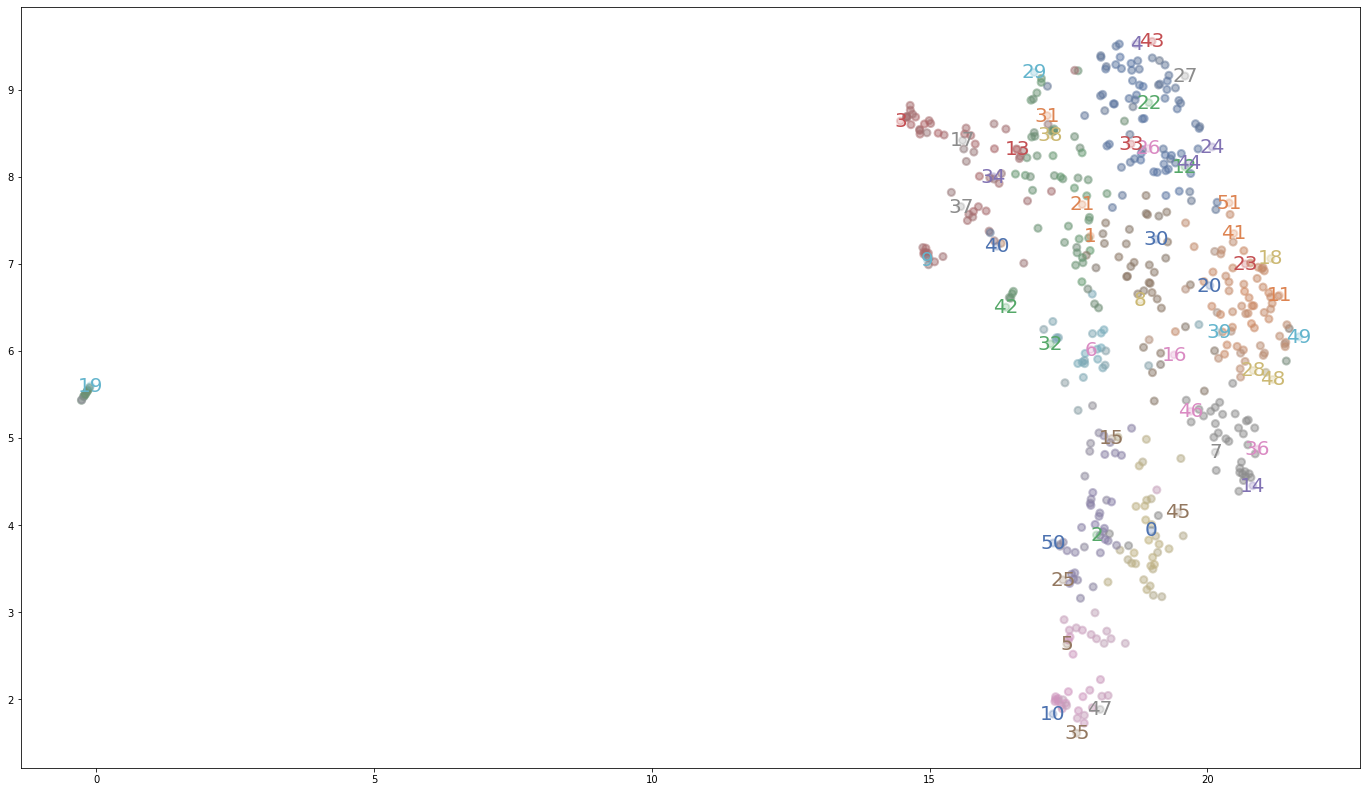

In [58]:
tm_model.generate_documents_plot()

In [18]:
topic_words, word_scores, topic_nums = tm_model.get_topics()

In [20]:
topic_words

array([['variance', '변수', 'covariance', ..., 'optimization',
        'interactions', 'data'],
       ['neural', 'neurons', 'networks', ..., 'correlations', 'nucleus',
        'correlated'],
       ['tutorial', '학습', 'learning', ..., '우분투', 'html', 'programs'],
       ...,
       ['mask', 'fsl', 'mxpath', ..., 'patients', 'text', 'questions'],
       ['groups', 'activation', 'group', ..., '파티션', 'movement', '부분'],
       ['apk', 'android', '우분투', ..., '과정', 'safari', 'version']],
      dtype='<U15')

In [19]:
topic_nums

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54])

In [61]:
#[list(zip(topic_words[i],word_scores[i]))for i in range(len(topic_nums))]

In [62]:
list(zip(topic_nums, zip(topic_words,word_scores)))

[(0,
  (array(['python', 'numpy', '파이썬', 'tensorflow', 'function', 'kwargs', '변수',
          'integers', 'functions', 'args', 'computational', 'github',
          'coding', 'preprocessing', 'algorithm', 'dataset', 'matlab',
          'encoding', 'nipype', 'variables', 'functional', 'module',
          'processes', 'variable', 'optimization', 'import', '기능',
          'parameter', '인코딩', 'ubuntu', '코드', 'array', 'program', 'linux',
          'hippocampus', 'mozilla', 'code', 'utf', 'func', 'py',
          'parameters', 'tutorial', '프로세스', 'kernel', 'keyword',
          'processing', 'xorg', 'foldername', 'process', '과정'], dtype='<U15'),
   array([0.4201187 , 0.3455378 , 0.33073246, 0.24728239, 0.2161268 ,
          0.21596757, 0.20947121, 0.20243955, 0.1959648 , 0.18737306,
          0.17879285, 0.17821383, 0.17776805, 0.17606455, 0.17278647,
          0.17003119, 0.16345873, 0.1625199 , 0.16095081, 0.15987577,
          0.15768597, 0.15459798, 0.15069339, 0.14444137, 0.14292023,
      

In [27]:
topic_num = 19
num_docs = tm_model.get_topic_sizes()[0][topic_num]
 
documents, document_scores, document_ids = tm_model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)
print(f"topic_num: {topic_num}, The number of Document: {num_docs}")
print(topic_words[topic_num], '\n')

for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}, URL: {docs_info_prep_df['url'][doc_id]}")
    print(doc)
    print()

topic_num: 19, The number of Document: 9
['neuroscience' 'neurons' 'neural' 'neuroimaging' 'brain' '신경망' 'cerebral'
 'midbrain' 'cognitive' 'memory' '메모리' 'nucleus' 'alzheimer' 'mental'
 'computational' 'psychology' 'intelligence' 'hippocampus' 'mind'
 'scientific' 'scientists' 'concepts' 'temporal' '과학' 'computer' 'science'
 'researchers' 'theoretical' 'cortex' 'coefficients' 'dementia'
 'selection' 'cells' 'humans' 'disorders' 'ability' 'correlated' 'studies'
 'mice' 'functions' 'dopamine' 'theory' '계산' '연구' 'clinical' 'groups' '시간'
 'symptoms' '개념' 'module'] 

Document: 161, Score: 0.8514077067375183, URL: https://www.ncbi.nlm.nih.gov/pubmed/28465167/
the neural basis of delay discounting : a review and preliminary model . the phenomenology of delay discounting ( e . g . shape of the discount function ; relation to mental health ) has been reviewed in detail previously , but not its neural substrates . its neuropsychology is crucial for both theory and clinical practice . so , here 

[(161,
  'the neural basis of delay discounting : a review and preliminary model . the phenomenology of delay discounting ( e . g . shape of the discount function ; relation to mental health ) has been reviewed in detail previously , but not its neural substrates . its neuropsychology is crucial for both theory and clinical practice . so , here , we review the neural underpinnings of delay discounting . we introduce its objective summary measures ; provide an atheoretical summary of current findings - linking brain regions to each objectively measurable variable ; and then provide a preliminary five - stage summary model of cognitive processing ; followed by a mapping of parameters to the flow of information through neural systems . the whole is designed to stimulate future research on the roles of each brain region in delay discounting . delay and payoff produce activity in many brain areas : thalamus ; sensory , parietal , temporal , cingulate , prefrontal , motor , and insular corte

In [67]:
document_ids

array([ 83, 123, 125, 313,  86, 195, 349, 258, 191, 203])

## 문서 추가

In [ ]:
url = ""
doc_info = crawling(url)
doc_info['content'] = preprocessing(doc_info['content'])

tm_model.add_documents([doc_info['content']])

## 결과 확인

In [52]:
tm_model.documents

array(["제 가 오랫동안 업데이트 를 하 지 않 았 네요 . 2020 . 01 . 21 . 업데이트 노트 지금 16 , 18 버전 이 나온 상황 에서 가장 좋 은 방법 은 루트 경로 ( '/') 에 50 gb 정도 를 파티션 분할 하 시 고 , 나머지 세부 적 인 파티션 은 안 잡 고 루트 에 우분 트 설치 하 는 것 이 나중 에 문제 가 발생 하 지 않 는 것 같 습니다 . 제 가 쓰 는 건 ubuntu 14 . 04 . 4 lts 버전 입니다 . 특별히 다른 이유 가 있 지 않 는 한 반드시 x 86 , amd 64 , intel 64 시스템 의 경우 다음 과 같 은 파티션 을 생성 하 는 것 이 좋 습니다 : swap 파티션 ( 일반 적 으로 메모리 의 1 ~ 2 배 정도 ) / boot 파티션 ( 1 gb ) / 파티션 ( 30 gb ~ 50 gb 이상 하 시 길 바랍니다 . ) / home 파티션 ( 나머지 용량 의 대부분 ) 제 가 실제 ubuntu install 과정 에서 나눈 파티션 ( 2 tb 기준 ) 순서 대로 파티션 생성 하 시 길 권장 합니다 . swap - 32 gb ( 주 파티션 , 스왑 ) 스왑 파티션 은 가상 메모리 를 지원 하 는 데 사용 됩니다 . 즉 , 시스템 이 처리 하 는 데이터 를 저장 할 ram 이 충분 하 지 않 을 때 스왑 파티션 에 자료 가 기록 됩니다 . 저희 랩 실에 ddr 4 16 gb 쓰 고 있 기 때문 에 32 gb 로 설정 해 줬 습니다 . / - 50 gb ( 주 파티션 , ex 4 ) 저희 연구실 특성 상 linux 에 install 할 프로그램 이 많 아서 / 파티션 의 용량 을 크 게 잡 았 습니다 . 50 gb 정도 로 잡 았 는데 지금 실제 사용량 이 16 gb 입니다 . 용량 이 넉넉 하 다면 30 ~ 50 gb 정도 잡 아 주 시 면 될 것 같 습니다 . / boot - 1 gb ( 주 파티션 , ex 4 ) boot 할 때 필요 한 파일 들 이 있 는 곳 입니다 . 저희 랩 실 컴 

In [136]:
tm_model.topic_vectors

array([[ 0.02985899,  0.00702338,  0.03298181, ..., -0.02406671,
        -0.01011761, -0.01616236],
       [ 0.04705388,  0.01554895,  0.05243341, ..., -0.0263309 ,
        -0.02338754, -0.00619072],
       [-0.02621372, -0.05594452,  0.04307705, ...,  0.00522114,
        -0.03448213, -0.00088639],
       ...,
       [ 0.05135854, -0.01419439,  0.02774981, ..., -0.01838074,
        -0.01491925,  0.03540744],
       [-0.00080602, -0.01290679, -0.02836154, ..., -0.01359722,
        -0.00042282,  0.00497828],
       [ 0.01520054, -0.00225542,  0.05499439, ...,  0.02658116,
        -0.0401808 ,  0.00094629]], dtype=float32)

In [116]:
# print(tm_model._get_document_vectors().shape)
# print(tm_model._find_topic_words_and_scores(tm_model.topic_vectors)[0])

(100, 512)
[['세계' '시장' '미국' '방송' '인터넷' '기업' '삼성전자' '분야' '한국' '최근' '서비스' '전자' '가능'
  '국내' '통신' '세포' '산업' '사업' '기술' '위성' 'tv' '연구원' '우주' '사람' '아니' '제품' '개발'
  '과학' 'it' '업체' '박사' '연구' '교수' 'lg' '만들' 'lcd' '공룡']
 ['과학' '박사' '연구원' '교수' '우주' '기술' '분야' '연구' '가능' '세계' '사람' '아니' '한국' '세포'
  '최근' '공룡' '전자' 'it' '위성' '삼성전자' '인터넷' '만들' '업체' '미국' 'tv' '제품' '통신'
  '기업' '산업' '개발' 'lg' '방송' '국내' '사업' '서비스' '시장' 'lcd']
 ['공룡' '과학' '우주' '연구원' '세계' '교수' '위성' '한국' '분야' '연구' '박사' '아니' '기술' '최근'
  '가능' '인터넷' '사람' '국내' '방송' '통신' 'tv' '만들' 'it' '미국' '제품' '전자' '서비스' '세포'
  '삼성전자' '개발' '산업' 'lcd' '시장' 'lg' '기업' '사업' '업체']
 ['세포' '과학' '연구' '연구원' '세계' '최근' '박사' '제품' '방송' '교수' '우주' '시장' '만들' '사람'
  '가능' '통신' '위성' '공룡' '개발' '아니' '인터넷' 'tv' '전자' '분야' '기업' '사업' '국내' '서비스'
  '삼성전자' 'it' '기술' '산업' '업체' 'lcd' '한국' 'lg' '미국']
 ['삼성전자' 'tv' 'lcd' '한국' '국내' 'lg' '방송' '제품' '기업' '산업' '사업' '세계' '전자'
  '업체' '시장' '최근' '인터넷' '미국' '서비스' '세포' '연구원' '기술' '위성' '가능' '개발' '분야'
  '과학' '우주' '통신' '연구' 'it' '교수' '아니' '만들' '사람' '공룡' '박사']

In [53]:
tm_model.get_documents_topics()

TypeError: get_documents_topics() missing 1 required positional argument: 'doc_ids'

In [146]:
for i, label in enumerate(tm_model.cluster.labels_):
    #print(label)
    if label == 1:
        print(tm_model._get_document_vectors()[i])

[-0.01363029 -0.01991915  0.04504409  0.02407508  0.01376904 -0.04487069
 -0.0501462   0.01771512  0.06055494  0.03132546  0.00167156 -0.01354191
 -0.04926852 -0.04723667  0.02061645  0.00910815  0.0515699   0.03017685
  0.00478582 -0.00490824  0.01557587  0.05236544  0.03524302 -0.01078077
 -0.06293938  0.0377364  -0.04593203 -0.02032631  0.04425114  0.0342423
 -0.05263076 -0.04710222 -0.02094551 -0.00366892 -0.03232541  0.02412808
  0.05387568 -0.06604341 -0.04893659  0.02671479  0.02434639  0.05341553
  0.06431236 -0.05173559 -0.02426996 -0.06137962 -0.06070521 -0.05711925
  0.0098163  -0.02262174  0.00625316 -0.04437137  0.00638726  0.02271413
  0.00860899 -0.06365182 -0.05120245 -0.01136659 -0.035421    0.01471635
 -0.01154089  0.05643941 -0.06728089 -0.03204541 -0.06299563 -0.04325141
  0.03700682 -0.06595489 -0.04798143 -0.01816374  0.02889401  0.05745589
  0.06328942  0.01973328  0.05269263 -0.03141433  0.04302338 -0.00578488
  0.0165673  -0.06828705 -0.05433786 -0.06635506  0.

In [147]:
tm_model.topic_vectors.shape

(18, 512)

In [148]:
tm_model._get_document_vectors().shape

(100, 512)

- topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.

- word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.

- topic_nums: The unique index of every topic will be returned.

In [4]:
# # !pip install hickle
# import hickle as hkl

# topic model

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from prepo.topic_model import TopicModel
from prepo import utils 

In [7]:
docs_info_prep_df = utils.load_obj(DATA_DIR, 'choi_urls/docs_info_prep_df.pkl')
docs_info_prep_df

,title,publish_date,contents,url,crawl_at,is_news,clip_at,contents_prep,contents_prep_sum
0,Bivariate Probit and Logit Models,None,\n\n\n\n\n\n\n\n\n\n\n\nThere are no videos fo...,https://sites.google.com/site/econometricsacad...,2020-11-04 12:36:11.015926,False,2015-11-05 13:58:24,bivariate probit and logit models . there are ...,bivariate probit and logit models . there are ...
1,Variance inflation factor,None,"In statistics, the variance inflation factor (...",https://en.wikipedia.org/wiki/Variance_inflati...,2020-11-04 12:36:12.470149,False,2015-11-05 14:09:24,"variance inflation factor . in statistics , th...",it turns out that the square of this standard ...
2,Statistical Analysis with Missing Data,None,Praise for the First Edition of Statistical An...,http://onlinelibrary.wiley.com/book/10.1002/97...,2020-11-04 12:36:13.857509,False,2015-11-05 17:24:55,statistical analysis with missing data . prais...,statistical analysis with missing data . prais...
3,Data Analysis,None,DATA ANALYSIS NOTES: LINKS AND GENERAL GUIDELI...,https://www.princeton.edu/~otorres/Stata/statn...,2020-11-04 12:36:18.837473,False,2015-11-08 22:23:54,data analysis . data analysis notes : links an...,!! data analysis : annotated output exploring ...
4,고지방 식이가 뇌에도 영향을 준다?,2017-11-05 01:00:11+09:00,지방은 사실 반드시 필요한 영양소다. 여러 필수 지방산은 우리가 생존하는 데 있어 ...,http://ppss.kr/archives/47698,2020-11-04 12:36:23.706657,False,2015-11-09 01:26:38,고지방 식이 가 뇌 에 도 영향 을 준다 ? . 지방 은 사실 반드시 필요 한 영양...,루이지애나 주립 대학 의 연구자 들 은 저널 ‘ biological psychiat...
...,...,...,...,...,...,...,...,...,...
529,MULTI GPU환경에서 ETRI 한국어 BERT모델 활용한 Korquad 학습 방법,None,We use optional third-party analytics cookies ...,https://github.com/domyounglee/korbert-mecab-m...,2020-11-04 12:51:16.270920,False,2020-10-15 20:21:09,multi gpu 환경 에서 etri 한국어 bert 모델 활용 한 korquad ...,multi gpu 환경 에서 etri 한국어 bert 모델 활용 한 korquad ...
530,NLP 비전공자가 챗봇 프로젝트를 구현하기까지,2019-11-16 16:12:00+09:00,"안녕하세요. Universtiy of California, San Diego에서 P...",https://brunch.co.kr/@ljh0113m/1,2020-11-04 12:51:16.492966,False,2020-10-15 20:21:56,nlp 비 전공 자 가 챗 봇 프로젝트 를 구현 하 기 까지 . 안녕 하 세요 . ...,"우선 , 멀티 캠퍼스 교육 과정 을 통해 각각 의 다른 전공 과 배경 을 가지 고 ..."
531,Topic Modeling with BERT,2020-10-06 06:48:38.700000+00:00,Image by the author.\n\nTopic Modeling with BE...,https://towardsdatascience.com/topic-modeling-...,2020-11-04 12:51:19.294852,False,2020-10-15 20:24:59,topic modeling with bert . image by the author...,"moreover , i wanted to use transformer - based..."
532,Building a personal knowledge base — Blog — Ki...,None,I try to unload all information that has any m...,https://kirillmaltsev.net/blog/personal-knowle...,2020-11-04 12:51:20.621195,False,2020-10-19 18:09:14,building a personal knowledge base — blog — ki...,"in this blog post , i ’ m going to describe my..."


In [151]:
x_list, y_list = get_node_locs(in_df)
locations = [{'x':x, 'y':y} for x,y in zip(temp1,temp2)]
for idx, data in enmerate(user_docs_df[:2].to_dict('records')):
    temp.append({'data': data,
                'position': locations[idx]})

[{'title': 'Bivariate Probit and Logit Models',
  'publish_date': None,
  'contents': '\n\n\n\n\n\n\n\n\n\n\n\nThere are no videos for this topic, but if you understand probit and logit models, you can learn this topic by viewing the handouts and programs.',
  'url': 'https://sites.google.com/site/econometricsacademy/econometrics-models/bivariate-probit-and-logit-models',
  'crawl_at': Timestamp('2020-11-04 12:36:11.015926'),
  'is_news': False,
  'clip_at': Timestamp('2015-11-05 13:58:24'),
  'contents_prep': 'bivariate probit and logit models . there are no videos for this topic , but if you understand probit and logit models , you can learn this topic by viewing the handouts and programs .'},
 {'title': 'Variance inflation factor',
  'publish_date': None,
  'contents': "In statistics, the variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone.[1] It quantifies the severity of multicollinearity in 

In [8]:
user_docs_df = docs_info_prep_df

In [24]:
%%time

# embedding_model은 tf hub를 사용하여 한 번 받으면 캐싱되어 그 이후에는 재다운 받지 않음
# universal-sentence-encoder-multilingual
# https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
# 16 languages (Arabic, Chinese-simplified, Chinese-traditional, English, French, German, Italian, Japanese, Korean, Dutch, Polish, Portuguese, Spanish, Thai, Turkish, Russian) 
my_tm_model = TopicModel(user_docs_df['contents_prep'], 
                   doc_ids=user_docs_df.index,
                  )

2020-11-10 18:07:44,503 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2020-11-10 18:07:47,259 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model


2020-11-10 18:07:50,565 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


2020-11-10 18:08:46,876 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2020-11-10 18:08:50,409 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2020-11-10 18:08:50,430 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


CPU times: user 2min 53s, sys: 45 s, total: 3min 38s
Wall time: 1min 6s


In [12]:
my_tm_model.get_topics_info()

{'topic_idxes': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72]),
 'topics_words': array([['matplotlib', 'dataframe', 'multiprocessing', ..., 'computing',
         'simulations', 'parameters'],
        ['sklearn', '강좌', 'tutorial', ..., 'github', 'elementary',
         'teacher'],
        ['scientist', 'fiction', 'scientists', ..., 'darwin',
         'scientific', 'triggered'],
        ...,
        ['ssh', 'github', 'stdout', ..., '파이썬', 'implements', 'toolbox'],
        ['apk', '컴파일', '컴파일러', ..., 'vtk', 'divided', 'coded'],
        ['statistical', 'statistically', 'statistics', ..., 'estimators',
         'quantitatively', 'graphql']], dtype='<U15'),
 'topic_vectors': array([[-0.05679963, -0.01546854, -0.0

In [13]:
len(my_tm_model.get_topics_info()['topics_words'])

73

In [14]:
my_tm_model.get_topics_info_as_dict_list()

[{'topic_idx': 0,
  'topic_words': array(['matplotlib', 'dataframe', 'multiprocessing', 'tensorflow',
         'dataset', 'ggplot', 'numpy', 'datasets', 'matlab', 'subprocess',
         'computationally', 'lineplot', 'algorithms', 'scatterplot',
         'computational', 'computation', 'algorithmic', 'parametric',
         '파라미터', 'algorithm', 'correlations', 'correlation', 'mxmatrix',
         'sklearn', 'graphql', 'quantitative', 'calculations', 'data',
         'computed', 'nonparametric', '회귀분석', 'calculation', 'segmentation',
         'integrating', 'morphometry', 'optimize', 'subset', 'integrative',
         'optimization', 'bmatrix', '알고리즘', 'multivariate', 'convolutional',
         'quantitatively', 'statistics', 'integration', 'optimizing',
         'computing', 'simulations', 'parameters'], dtype='<U15'),
  'topic_vector': array([-5.67996278e-02, -1.54685425e-02, -2.62139291e-02,  1.01699894e-02,
         -3.97130512e-02, -5.64770885e-02,  1.10536600e-02,  1.23515204e-02,
   

In [16]:
my_tm_model.reduce_topic(15)

In [17]:
my_tm_model.get_topics_info()

{'topic_idxes': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'topics_words': array([['sklearn', 'teach', 'learning', 'learner', '학습', 'taught',
         'learns', '전공', 'neurosciences', 'neuroscience', 'neural',
         'undergraduate', 'faculty', 'neurosci', 'scholarship',
         'academic', 'scholar', 'learn', 'resource', 'teaching',
         'funding', 'courses', 'tutorial', 'funded', '강좌', 'classes',
         'education', 'bootstrap', 'studying', 'contribute', 'grant',
         'study', '학문', 'student', 'students', 'university', 'sciences',
         'beneficial', 'volunteer', 'professor', 'resources', '자원',
         'textbooks', 'training', 'contributes', '교수', 'fund', 'arxiv',
         'formation', 'promote'],
        ['neuronal', 'neurosciences', 'neurobiological',
         'neuroscientific', 'neuroscience', 'neurosci', 'neurogenesis',
         'neurobiology', 'neurons', 'neuro', 'neuron', 'neural',
         'neurological', 'neuroimaging', 'neuroethics

In [18]:
len(my_tm_model.get_topics_info()['topics_words'])

15

In [19]:
my_tm_model.get_topics_info_as_dict_list()

[{'topic_idx': 0,
  'topic_words': array(['sklearn', 'teach', 'learning', 'learner', '학습', 'taught',
         'learns', '전공', 'neurosciences', 'neuroscience', 'neural',
         'undergraduate', 'faculty', 'neurosci', 'scholarship', 'academic',
         'scholar', 'learn', 'resource', 'teaching', 'funding', 'courses',
         'tutorial', 'funded', '강좌', 'classes', 'education', 'bootstrap',
         'studying', 'contribute', 'grant', 'study', '학문', 'student',
         'students', 'university', 'sciences', 'beneficial', 'volunteer',
         'professor', 'resources', '자원', 'textbooks', 'training',
         'contributes', '교수', 'fund', 'arxiv', 'formation', 'promote'],
        dtype='<U15'),
  'topic_vector': array([-1.67752337e-02,  1.72124635e-02, -9.94471926e-03,  1.06960768e-02,
          2.38307398e-02, -1.53593952e-03,  1.09070716e-02,  3.94930458e-03,
          1.72648896e-02,  3.28083592e-03,  1.36826104e-02, -5.05149085e-03,
          4.47546458e-03, -8.05605296e-03, -4.81562093

In [21]:
topics_idx_vector, docs_idx_vector, words_idx_vector = my_tm_model.get_2d_vectors()
docs_idx_vector

[{'id': 0, 'x': 9.661947, 'y': 7.911528, 'topic_idx': 8},
 {'id': 1, 'x': 9.733882, 'y': 9.075437, 'topic_idx': 2},
 {'id': 2, 'x': 10.371698, 'y': 8.945484, 'topic_idx': 13},
 {'id': 3, 'x': 9.234382, 'y': 8.37953, 'topic_idx': 8},
 {'id': 4, 'x': 12.9025345, 'y': 6.01009, 'topic_idx': 1},
 {'id': 5, 'x': 8.668866, 'y': 8.199829, 'topic_idx': 3},
 {'id': 6, 'x': 12.077867, 'y': 7.9338036, 'topic_idx': 1},
 {'id': 7, 'x': 8.833753, 'y': 5.3362575, 'topic_idx': 0},
 {'id': 8, 'x': 12.449157, 'y': 3.9774396, 'topic_idx': 11},
 {'id': 9, 'x': 11.269434, 'y': 1.0597181, 'topic_idx': 4},
 {'id': 10, 'x': 11.58171, 'y': 4.1386633, 'topic_idx': 4},
 {'id': 11, 'x': 11.505918, 'y': 1.368509, 'topic_idx': 4},
 {'id': 12, 'x': 11.364411, 'y': 1.2545571, 'topic_idx': 4},
 {'id': 13, 'x': 6.2473702, 'y': 4.681127, 'topic_idx': 5},
 {'id': 14, 'x': 8.093265, 'y': 7.7633862, 'topic_idx': 3},
 {'id': 15, 'x': 12.366834, 'y': 6.414103, 'topic_idx': 1},
 {'id': 16, 'x': 4.817207, 'y': 4.848057, 'topic_

In [62]:
my_tm_model.get_links_info()[500:]

[['models' '모델' 'modelling' ... 'samples' 'modulation' 'neurobiology']
 ['variance' 'coefficient' 'regression' ... 'varlambda' '확률' 'estimators']
 ['statistically' 'statistical' 'statistics' ... 'impairments'
  'stability' 'vulnerability']
 ...
 ['clustering' 'topics' 'clusters' ... 'computationally' 'summarize'
  'infrastructure']
 ['storage' '저장' '기억력' ... 'datasets' '전략' '기록']
 ['clustering' 'topics' 'clusters' ... 'textrm' '클래스' 'summarize']]


[('doc_500', 'topic_23'),
 ('doc_501', 'topic_68'),
 ('doc_502', 'topic_7'),
 ('doc_503', 'topic_11'),
 ('doc_504', 'topic_11'),
 ('doc_505', 'topic_23'),
 ('doc_506', 'topic_56'),
 ('doc_507', 'topic_14'),
 ('doc_508', 'topic_24'),
 ('doc_509', 'topic_20'),
 ('doc_510', 'topic_41'),
 ('doc_511', 'topic_9'),
 ('doc_512', 'topic_25'),
 ('doc_513', 'topic_20'),
 ('doc_514', 'topic_37'),
 ('doc_515', 'topic_37'),
 ('doc_516', 'topic_10'),
 ('doc_517', 'topic_3'),
 ('doc_518', 'topic_25'),
 ('doc_519', 'topic_65'),
 ('doc_520', 'topic_65'),
 ('doc_521', 'topic_1'),
 ('doc_522', 'topic_32'),
 ('doc_523', 'topic_7'),
 ('doc_524', 'topic_23'),
 ('doc_525', 'topic_7'),
 ('doc_526', 'topic_7'),
 ('doc_527', 'topic_4'),
 ('doc_528', 'topic_25'),
 ('doc_529', 'topic_20'),
 ('doc_530', 'topic_62'),
 ('doc_531', 'topic_0'),
 ('doc_532', 'topic_1'),
 ('doc_533', 'topic_0'),
 ('word_2653', 'topic_0'),
 ('word_1047', 'topic_0'),
 ('word_4440', 'topic_0'),
 ('word_1048', 'topic_0'),
 ('word_1049', 'top

In [65]:
my_tm_model.vocab[:2]

['ab', 'abc']

In [67]:
user_docs_df = user_docs_df.reset_index(level=0).rename(columns={"index":"id", 'contents_prep_sum': 'text_sum'})

In [ ]:
pd.DataFrame(data=data[1:,1:],    # values
...              index=data[1:,0],    # 1st column as index
...              columns=data[0,1:])

In [79]:
pd.DataFrame(my_tm_model.get_documents_topics(user_docs_df['id'].values)[0], index=user_docs_df['id'].values).reset_index(level=0).rename(columns={"index":"id", 0: 'topic_idx'})

,id,topic_idx
0,0,6
1,1,15
2,2,10
3,3,9
4,4,43
...,...,...
529,529,20
530,530,62
531,531,0
532,532,1


In [37]:
topic_num_user_input = 20
my_tm_model.reduce_topic(topic_num_user_input)

In [38]:
my_tm_model.get_topics_info()

[{'topic_idx': 0,
  'topic_words': array(['matplotlib', 'ggplot', 'dataframe', 'lineplot', 'dataset',
         'scatterplot', 'datasets', 'matlab', 'tensorflow', 'xticklabels',
         'numpy', 'graphql', 'multiprocessing', 'data', 'algorithms',
         'parametric', 'graphs', 'sklearn', 'mxmatrix', 'vertexcount',
         'algorithmic', 'computationally', 'computational', 'boxplot',
         'computation', '파라미터', 'subprocess', 'algorithm', 'graph',
         'clustering', 'bmatrix', 'correlations', 'correlation', 'mxpath',
         'statistics', 'genome', '데이터', 'calculations', 'gaussian',
         'computed', 'quantitative', 'github', '알고리즘', 'calculation',
         'dzdata', 'statistical', 'nonparametric', 'subplots', 'mzdata',
         'statistically'], dtype='<U15'),
  'topic_vector': array([-5.39625734e-02, -1.99618135e-02, -2.29578372e-02,  3.86219472e-06,
         -3.83860432e-02, -5.12448289e-02,  2.00778265e-02,  1.71963442e-02,
          4.60006706e-02,  1.31648118e-02,  2

In [132]:
doc_ids = [469,473]

In [138]:
my_tm_model.get_documents_topics([4] + doc_ids)

(array([73,  4,  4]),
 array([0.7833977, 0.7542943, 0.5097479], dtype=float32),
 array([['groups', 'group', 'activation', 'activity', 'activities',
         'items', '영향', 'factors', 'negative', '기능', 'interactions',
         'tool', 'populations', 'food', 'article', 'tools', '효과',
         'interaction', 'feature', 'selection', 'areas', 'findings', '연구',
         'effects', 'extraction', 'genetic', 'team', 'species', '부분',
         'role', 'ants', 'arrows', 'functions', 'individuals', 'func',
         'organizations', 'features', 'teams', 'section', 'product',
         'interest', 'components', 'benefit', 'factor', 'researchers',
         'correlated', '유전자', 'humans', 'functional', 'effect'],
        ['population', '데이터', 'impairment', 'statistical', '발생',
         'statistics', 'populations', 'dropout', 'error', '영향', 'nouveau',
         'pain', 'effects', '다시', 'regression', 'public', 'latest',
         'data', '상황', 'effect', 'trying', 'symptoms', 'cases', 'recent',
         '패러다임

In [136]:
topic_num = 4
num_docs = my_tm_model.get_topic_sizes()[0][topic_num]
 
documents, document_scores, document_ids = my_tm_model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)
print(f"topic_num: {topic_num}, The number of Document: {num_docs}")
# print(topic_words[topic_num], '\n')

for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}, URL: {docs_info_prep_df['url'][doc_id]}")
    print(doc)
    print()

topic_num: 4, The number of Document: 12
Document: 469, Score: 0.7542942762374878, URL: https://www.google.co.kr/amp/s/m.biz.chosun.com/news/article.amp.html%3fcontid=2020051501319
신종 코로나 바이러스 감염증 ( 코로나 19 ) 이 확산 하 면서 작년 대비 5 8 % 수준 까지 떨어졌 던 국내 이 동량 이 황금연휴 때 8 3 % 수준 까지 회복 한 것 으로 나타났 다 . 1 5 일 sk 텔레콤 과 통계청 이 모바일 빅 데이터 를 기반 으로 분석 한 결과 , 2 월 2 9 일 ( 토요일 ) 전 국민 이 동량 은 2 5 0 3 만 건 으로 1 년 전 같 은 시기 ( 4307 만 건 ) 의 5 8 . 원정연 통계청 빅 데이터 통계 과장 은 " 코로나 19 감염자 가 늘어난 영향 으로 이 동량 이 줄 었 으며 , 특히 지역 집단 감염 이 발생 한 2 0 일 이후 첫 주말 인 2 9 일 에 가장 큰 폭 으로 줄어들 었 다 " 고 분석 했 다 . 이러 한 국내 인구 이 동량 은 통계청 이 국내 점유 율 4 2 % 를 차지 하 는 sk 텔레콤 의 모바일 이 동 데이터 를 토대 로 전 국민 수준 으로 변환 한 수 치 다 . 이 는 지난 7 일 서울 이태원 클럽 발 코로나 집단 감염 이 알려 지 기 시작 하 면서 이동 을 줄인 영향 으로 보인다 . 코로나 19 발생 이후 에 는 상업 지역 · 관광지 · 레저 스포츠 시설 이 주거 지역 보다 이 동량 감소 가 컸 다 . 다만 황금연휴 가 있 던 발생 후 1 3 주 차 에 는 관광지 , 레저 스포츠 시설 에서 이 동량 이 크 게 늘 었 다 .

Document: 468, Score: 0.7166489362716675, URL: https://www.google.co.kr/amp/s/m.yna.co.kr/amp/view/GYH20200515000800044
[ 그래픽 ] 코로나 19 발생 전

In [125]:
my_tm_model.get_docs_by_doc(doc_ids)

array([468, 470, 423])

In [143]:
my_tm_model.get_keywords_by_doc([4])

(array([['영향', 'effects', 'role', '효과', 'effect', 'food', 'activity',
         'activities', 'activation', '연구', 'increased', 'contribution',
         'factors', 'interactions', 'significantly', 'significant',
         'scientific', 'negative', 'significance', 'article', 'changes',
         'interest', 'findings', 'published', '변화', 'performance',
         'output', 'interaction', 'benefit', '작업', 'internal', 'movement',
         'ventral', '부분', 'tasks', 'things', 'functions', 'new',
         'researchers', 'observed', 'little', 'studies', 'factor',
         'positive', 'func', '기능', 'lower', 'works', 'items',
         'distributed']], dtype='<U13'),
 array([[0.24826243, 0.18974277, 0.17923524, 0.17731381, 0.17352056,
         0.17155015, 0.1655323 , 0.16119431, 0.15022378, 0.1475901 ,
         0.140185  , 0.13532774, 0.12363472, 0.12275739, 0.12215174,
         0.12113585, 0.12072752, 0.11677276, 0.11515312, 0.11481932,
         0.11420466, 0.11356058, 0.11297913, 0.11238598, 0.11224

In [140]:
my_tm_model.get_hot_keywords_by_docs([4] + doc_ids, [1,0,0])

(array(['영향', 'populations', 'population', 'statistics', '발생',
        'statistical', 'factors', 'findings', 'effects', 'correlations'],
       dtype='<U12'),
 array([0.18777566, 0.17245457, 0.17219058, 0.1574989 , 0.15602871,
        0.15092292, 0.14844488, 0.14490564, 0.14370645, 0.14241781]))

In [198]:
topics_idx_vector, docs_idx_vector, words_idx_vector = my_tm_model.get_2d_vectors()

topics_idx_vector_df = pd.DataFrame(topics_idx_vector)
docs_idx_vector_df = pd.DataFrame(docs_idx_vector)
words_idx_vector_df = pd.DataFrame(words_idx_vector)

In [199]:
topics_idx_vector_df['element_type'] ='topic'
topics_idx_vector_df['topic_idx'] = topics_idx_vector_df['id']
docs_idx_vector_df['element_type'] = 'doc'
words_idx_vector_df['element_type'] = 'word'
words_idx_vector_df['topic_idx'] = -1

temp_df = pd.concat([topics_idx_vector_df,docs_idx_vector_df, words_idx_vector_df])
temp_df

,id,x,y,element_type,topic_idx
0,0,12.271623,6.511519,topic,0
1,1,15.529943,5.850564,topic,1
2,2,7.517497,3.071488,topic,2
3,3,13.477629,2.486977,topic,3
4,4,8.730590,-1.422772,topic,4
...,...,...,...,...,...
813,358,-3.703612,17.719889,word,-1
814,1150,12.071407,1.585322,word,-1
815,443,7.419833,9.488334,word,-1
816,448,9.574939,0.447628,word,-1


In [202]:
temp_df['topic_idx'].value_counts()

-1     818
 0      20
 1      18
 2      15
 3      15
      ... 
 59      4
 58      4
 57      4
 70      4
 71      3
Name: topic_idx, Length: 73, dtype: int64

In [ ]:
my_tm_model.

In [108]:
from prepo import topic_model

In [110]:
import os
os.path.abspath(topic_model.__file__)

'/home/lab13/prepo/prepo/topic_model.py'

In [160]:
my_tm_model.get_topics_info()

[{'topic_idx': 0,
  'topic_words': array(['dataset', 'matlab', 'numpy', 'data', 'mxpath', 'tensorflow',
         'bmatrix', 'algorithm', '데이터', 'information', 'computational',
         'parameters', 'correlations', 'correlation', 'populations',
         'optimization', '회귀분석', 'regression', 'statistics', 'parameter',
         'integration', 'datetime', 'statistical', 'preprocessing', '정보',
         'correlated', 'population', 'patients', 'groups', '행렬', 'subjects',
         'distributed', 'neural', 'variables', 'analyses', 'analysis',
         'analytics', 'extraction', 'source', 'coefficients', 'individuals',
         'files', 'voxel', 'neurons', 'voxels', 'methods', 'openmx', 'fsl',
         'index', 'treatment'], dtype='<U15')},
 {'topic_idx': 1,
  'topic_words': array(['statistical', 'statistics', 'regression', 'probability',
         'variance', 'covariance', 'coefficients', 'predict', '회귀분석',
         'correlation', 'dataset', 'correlations', 'parameters', 'matlab',
         'pop

In [159]:
total_topic_words = set()
topic_vectors = []
for info in my_tm_model.get_topics_info():
    total_topic_words.update(info['topic_words'])
    topic_vectors.append(info['topic_vector'])
    
my_set

{'abc',
 'ability',
 'able',
 'access',
 'account',
 'activation',
 'activities',
 'activity',
 'actually',
 'ad',
 'add',
 'additional',
 'address',
 'adhd',
 'adolescents',
 'again',
 'age',
 'algorithm',
 'allows',
 'already',
 'alt',
 'alzheimer',
 'among',
 'amygdala',
 'analyses',
 'analysis',
 'analytics',
 'android',
 'anova',
 'answer',
 'ants',
 'anxiety',
 'aov',
 'apk',
 'app',
 'application',
 'applications',
 'applied',
 'apply',
 'approach',
 'approaches',
 'apt',
 'area',
 'areas',
 'args',
 'arguments',
 'array',
 'arrows',
 'article',
 'artificial',
 'arxiv',
 'assess',
 'associated',
 'association',
 'author',
 'authors',
 'auto',
 'available',
 'average',
 'basal',
 'based',
 'begin',
 'behavior',
 'behavioral',
 'behaviors',
 'behavioural',
 'benefit',
 'better',
 'between',
 'bias',
 'blog',
 'bmatrix',
 'body',
 'book',
 'boot',
 'born',
 'brain',
 'browser',
 'building',
 'by',
 'called',
 'cases',
 'caudate',
 'cdh',
 'cdt',
 'cell',
 'cells',
 'central',
 'cer

In [ ]:
my_tm_model.

In [ ]:
tm_model.get_topics_info()

In [ ]:
topics_docs = [{'topic_num': 4, 
  'docs':[{'docs_id': 469, 'title':'aaaaaaaaaa'},
          {'docs_id': 471, 'title':'aaaaaaaaaa'},
         ]
 },
 {'topic_num': 6, 
  'docs':[{'docs_id': 469, 'title':'aaaaaaaaaa'},
          {'docs_id': 471, 'title':'aaaaaaaaaa'},
         ]
 }]

topics_dic

#  이전

In [66]:
x = np.array([[0,2], [1,3], [2,4]])
y=np.array([1, 2, 3])

In [78]:
print(x)
x.shape

[[0 1]
 [2 2]
 [3 4]]


(3, 2)

In [68]:
y.shape

(3,)

In [69]:
y.reshape(-1,1)

array([[1],
       [2],
       [3]])

In [71]:
y.reshape(-1,1)*x

array([[ 0,  2],
       [ 2,  6],
       [ 6, 12]])

In [52]:
np.squeeze(x)

array([[0, 2],
       [1, 3],
       [2, 4]])

In [80]:
np.ravel(x)

array([0, 1, 2, 2, 3, 4])

In [82]:
np.flip((np.argsort(np.ravel(x))))

array([5, 4, 3, 2, 1, 0])

In [ ]:
np.argsort(x)

In [49]:
urlparse(test_urls[0]).netloc

'www.nytimes.com'

In [90]:
url = 'http://promotion.gmarket.co.kr/Event/CouponZone.asp'
newspaper.urls.valid_url(test_urls[2])

False

In [3]:
import importlib
importlib.reload(re)

<module 're' from '/home/lab13/anaconda3/envs/top2vec/lib/python3.6/re.py'>

In [5]:
import sys
sys.path

['/home/lab13/anaconda3/envs/top2vec/lib/python36.zip',
 '/home/lab13/anaconda3/envs/top2vec/lib/python3.6',
 '/home/lab13/anaconda3/envs/top2vec/lib/python3.6/lib-dynload',
 '',
 '/home/lab13/anaconda3/envs/top2vec/lib/python3.6/site-packages',
 '/home/lab13/anaconda3/envs/top2vec/lib/python3.6/site-packages/IPython/extensions',
 '/home/lab13/.ipython']

In [79]:
article = newspaper.Article(url)  # , language='ko'
article.download()  # request

In [80]:
article.parse()
article.title

ArticleException: Article `download()` failed with No connection adapters were found for ':/www.gmarket.co.kr' on URL :/www.gmarket.co.kr

In [ ]:
p = re.compile('[a-z]+')

In [66]:
sensitive_webpage_dict = {
    'Shopping': ['gmarket.co.kr','auction.co.kr','11st.co.kr','coupang.com','tmon.co.kr','interpark.com','ssg.com','wemakeprice.com','danawa.com','yes24.com','amazon.com','ebay.com','amazon.co.jp','amazon.co.uk','ppomppu.co.kr',],
    "OTT": ['youtube.com','netflix.com','melon.com','afreecatv.com','pandora.tv','wavve.com','twitch.tv','gomtv.com','toptoon.com',],
    "SNS/Community": ['dcinside.com','fmkorea.com','humoruniv.com','facebook.com','instagram.com', 'twitter.com'],
    "Cloud": ['dropbox.com','drive.google.com',],
}

def check_sensitive_webpage(url, sensitive_webpage_types=None):
    #assert isinstance(sensitive_webpage_types, collections.Iterable), "sensitive_webpage_types should be iterable type"
    
    if sensitive_webpage_types is None:
        return False
    else:
        netloc = urlparse(url).netloc
        for type in sensitive_webpage_types:
            print(sensitive_webpage_dict[type])
            print(urlparse(url))
            if netloc in sensitive_webpage_dict[type]:
                return True
        return False
            
print(check_sensitive_webpage('gmarket.co.kr', ['Shopping']))

['gmarket.co.kr', 'auction.co.kr', '11st.co.kr', 'coupang.com', 'tmon.co.kr', 'interpark.com', 'ssg.com', 'wemakeprice.com', 'danawa.com', 'yes24.com', 'amazon.com', 'ebay.com', 'amazon.co.jp', 'amazon.co.uk', 'ppomppu.co.kr']
ParseResult(scheme='', netloc='', path='gmarket.co.kr', params='', query='', fragment='')
False


In [78]:
urlparse('www.gmarket.co.kr')

ParseResult(scheme='', netloc='', path='www.nytimes.com/2020/10/20/us/politics/stimulus-deal-mitch-mcconnell-nancy-pelosi.html', params='', query='action=click&module=Top%20Stories&pgtype=Homepage', fragment='')

In [76]:
url = 'www.gmarket.co.kr'
scheme = newspaper.urls.get_scheme(url)
if scheme is None:
    scheme = 'http'
source_url = scheme + '://' + newspaper.urls.get_domain(url)
source_url

''

In [70]:
urlparse(test_urls[0])

ParseResult(scheme='https', netloc='www.nytimes.com', path='/2020/10/20/us/politics/stimulus-deal-mitch-mcconnell-nancy-pelosi.html', params='', query='action=click&module=Top%20Stories&pgtype=Homepage', fragment='')

In [39]:



for url in test_urls:
    urls_component.append()
    
urls_can_parse_df = pd.DataFrame(data=urls_component)
urls_can_parse_df['can_parse'] = True
urls_can_parse_df

In [ ]:
다음주시작&내년자격증 반